# Proyecto 04 Integrador - Series de Tiempo


### Creado por: Juan David Rincón
#### jdrincone@gmail.com
#### [**Portafolio de proyectos**](https://jdrincone.github.io/Portafolio/)

<a id="s-0"></a>
*  [**EDA**](#s-1)
    - [Realizado en el proyecto 3](https://github.com/jdrincone/Flujo-Vehicular)
     
   [**Modelo: Medias Moviles y suvización**](#s-2)
   - [Benchmark-Holt-Winters](#s-21)
   - [SARIMA](#s-22)
   - [Regresión lineal](#s-3)
   - [xgboots](#s-4)
   - [Prophet](#s-5)
   
  [**Comparación modelos**](#s-6) 
      
  [**Conclusiones**](#s-7) 
  



## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Pregunta a responder:** *¿Sobre la autopista Illia, existen datos de serie de tiempo que se comporten de forma estacionaria? Si es asi, ¿Como se comportan los modelos para este conjunto de datos? ¿Qué nueva información podemos extraer?*
- Modelos avanzados de pronóstico: *¿Cual elegir?*

### Exploración de datos

[Ver el proyecto anterior](https://github.com/jdrincone/Flujo-Vehicular)
#### Componentes de la serie

[Ver el proyecto anterior](https://github.com/jdrincone/Flujo-Vehicular)

### Predicción a Futuro
Este sera nuestro punto de partida en este proyecto. ``Predecir el futuro`` con **nuevos modelos** no explorados [antes](https://github.com/jdrincone/Flujo-Vehicular) sobre dos series de tiempo: Vehiculos que transitan por Illia y usan efectivo y telepase como forma de pago. 

Con el ojbetivo de responder la pregunta anterior, aquí realizaremos:

- Visualización de la serie temporal con frecuencia diaria
- Suvización de los datos 
- Detección extricta de valores atípicos
- Definición de métrica adecuada para la toma de decisión según el tipo de datos
- Entrenamiento de modelo Benchmark-Holt-Winters
- Entrenamiento y pronóstico modelo SARIMA 
- Entrenamiento y pronóstico modelo de regresión lineal
- Entrenamiento y pronóstico modelo de xgboost
- Entrenamiento y pronóstico modelo prophet

En este trabajo se empleará los métodos tradicionales (ARIMA, SARIMA y/o SARIMAX) para pronosticar los valores de cantidad de autos que pagarán en efectivo ypor telepase cada día por cada una de las estaciones de peaje.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

sns.set(font_scale=1)
from matplotlib import rc
rc('text', usetex=False)
rc('font', family='serif')
# colores
c1 = '#121d27'
c2 = '#12404d'
c3 = '#146e7e'
c4 = '#1aa5bb'
c5 = '#20dad8'
c6 = '#002e00'
c7 = '#005d5d'
c8 = '#ff0e4d'
c9 = '#ffc630'
c10 = '#f4ffb5'
c11 = '#002e00'
c12 = '#005d5d'
c13 = '#ff0e4d'
c14 = '#ffc630'
c15 = '#f4ffb5'


import warnings
warnings.filterwarnings('ignore')

In [2]:
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')

In [3]:
def df(estation, pago, freq):
    data =pd.concat([data_2019, data_2018, data_2017])
    d = data[(data.estacion == estation) & (data.forma_pago == pago)]
    d.fecha =  pd.to_datetime(d.fecha,dayfirst = True) + pd.to_timedelta(d.hora_fin, unit = 'h')
    d.sort_values('fecha', inplace = True)
    d.reset_index(drop=True, inplace = True)
    df =d[['fecha','cantidad_pasos']]
    df = df.resample(freq, on = 'fecha').sum()
    return df 

<a id="s-1"></a>
#### Grafiquemos el número de vehiculos que transicurren por ``Illia`` y su medio de pago es efectivo

In [4]:
u = df('Illia','EFECTIVO', 'd')

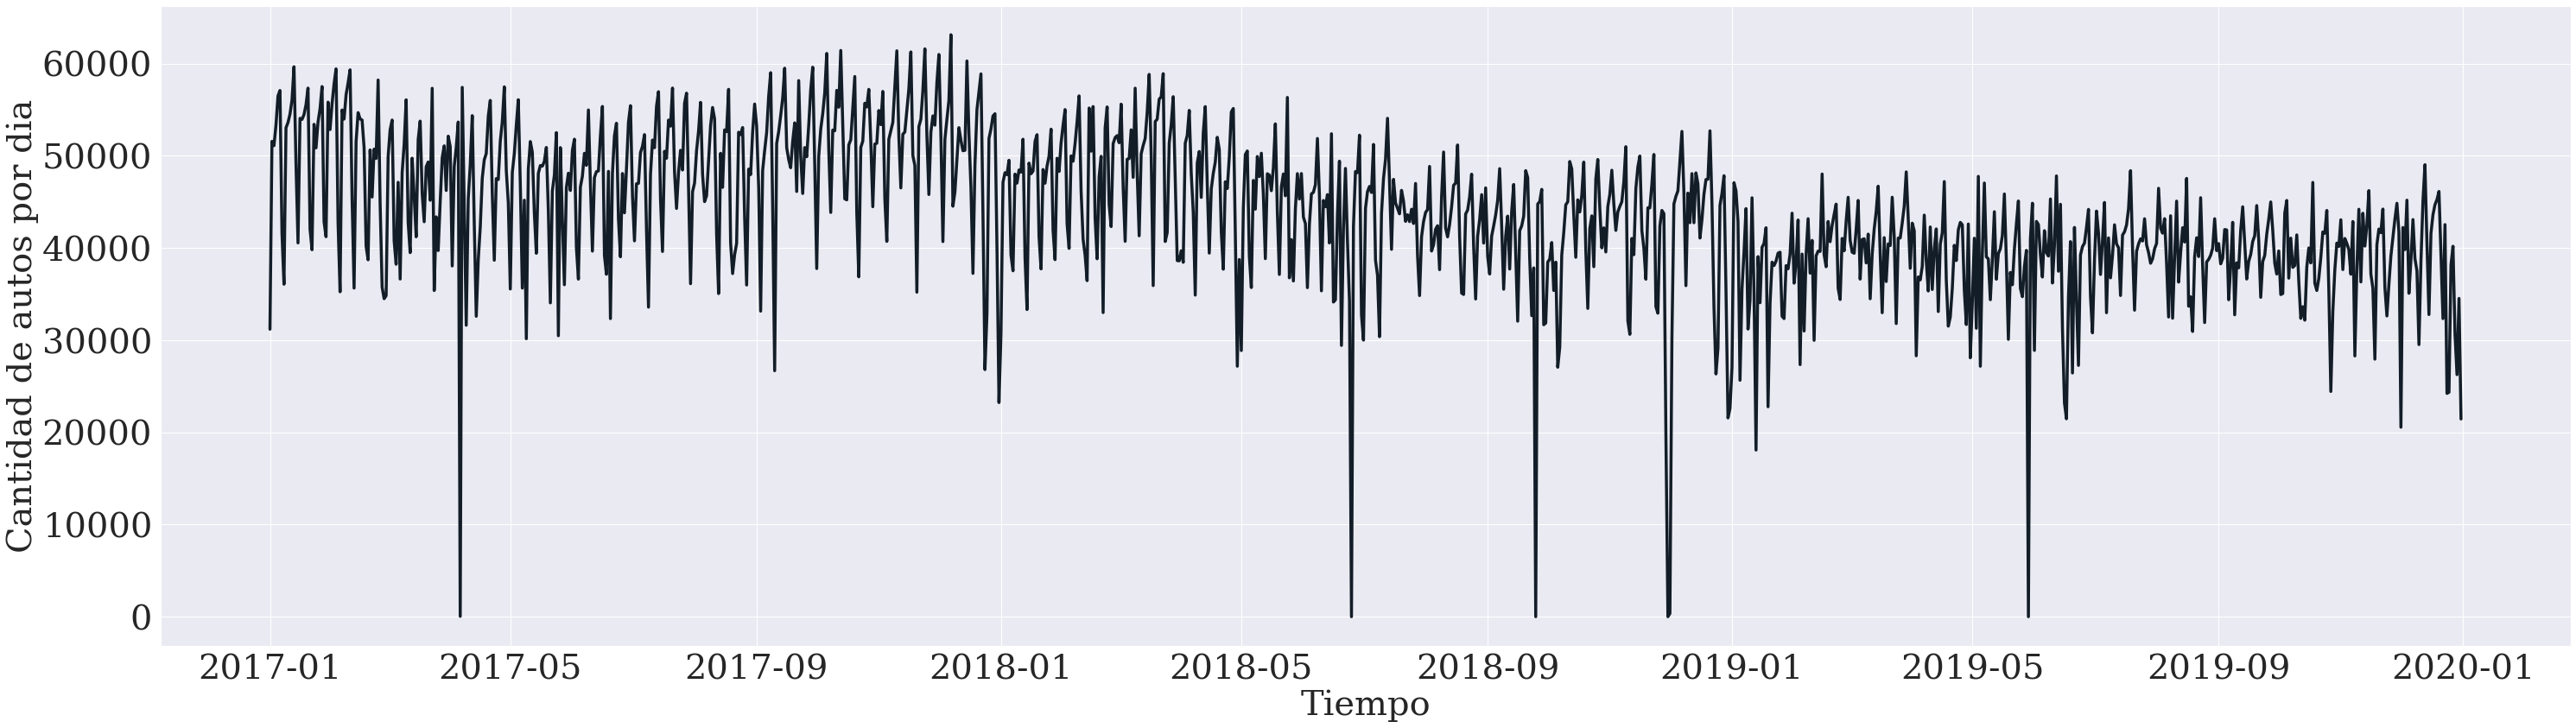

In [5]:
plt.figure(figsize=(50,30));
ax1 = plt.subplot(211);
ax1 = sns.lineplot( x=u.index, y=u.cantidad_pasos, color = c1,lw = 3.5 );
#ax1.legend(fontsize=30,shadow=True);
ax1.grid(True);
plt.setp(ax1.get_yticklabels(), visible=True,fontsize = 40);
plt.setp(ax1.get_xticklabels(), visible=True,fontsize = 40);
plt.xlabel('Tiempo',fontsize = 40)
plt.ylabel('Cantidad de autos por dia',fontsize = 40);


#### Grafiquemos el número de vehiculos que transicurren por ``Illia`` y su medio de pago es telepase.

In [6]:
w = df('Illia','TELEPASE', 'd')

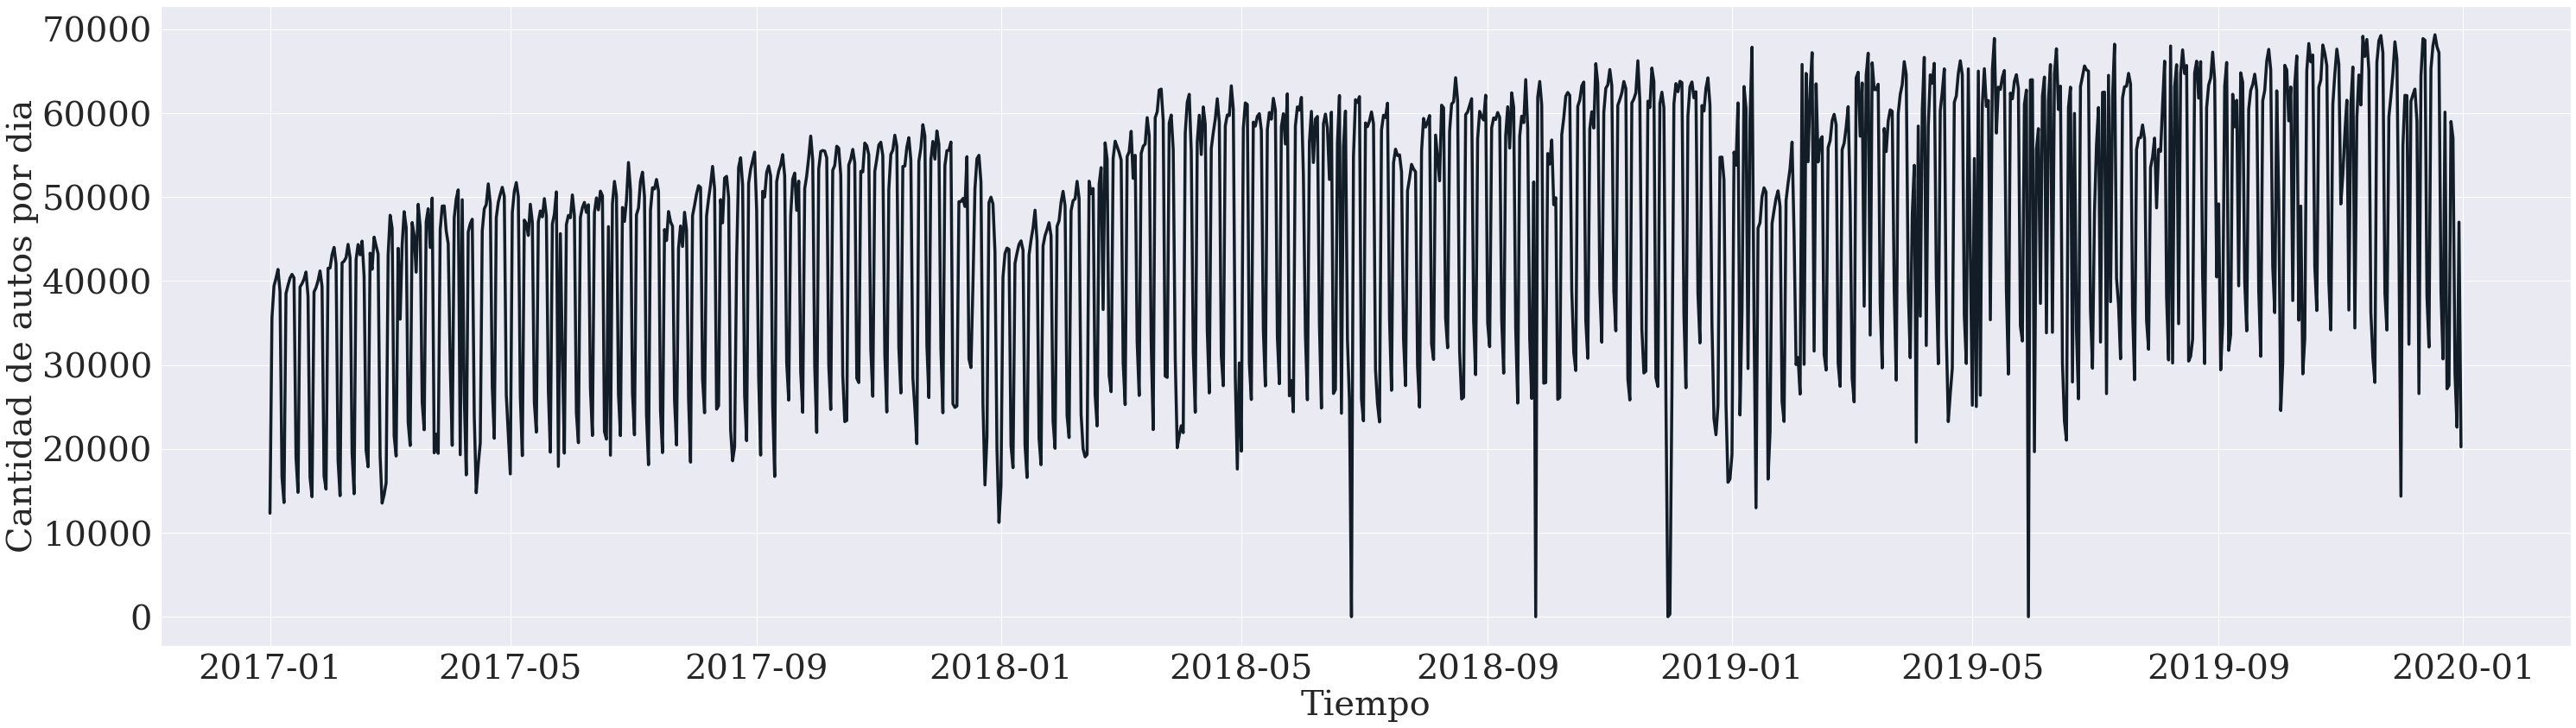

In [7]:
plt.figure(figsize=(50,30));
ax1 = plt.subplot(211);
ax1 = sns.lineplot( x=w.index, y=w.cantidad_pasos, color = c1,lw = 3.5 );
#ax1.legend(fontsize=30,shadow=True);
ax1.grid(True);
plt.setp(ax1.get_yticklabels(), visible=True,fontsize = 40);
plt.setp(ax1.get_xticklabels(), visible=True,fontsize = 40);
plt.xlabel('Tiempo',fontsize = 40)
plt.ylabel('Cantidad de autos por dia',fontsize = 40);

## Métrica de evaluación
En este caso usaremos Error Porcentual Absoluto Medio (``MAPE``) es un indicador del desempeño del Pronóstico de Demanda que mide el tamaño del error (absoluto) en términos porcentuales. El hecho que se estime una magnitud del error porcentual lo hace un indicador frecuentemente utilizado por los encargados de elaborar pronósticos debido a su fácil interpretación.
\begin{equation}
MAPE=\frac{100%}{n}\sum_{i=0}^n\frac{y_{i}-\hat{y}}{y_{i}}
\end{equation}


In [8]:
#Definición de las métricas

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

<a id="s-2"></a>
## Modelo: Medias Moviles y suvización
Iniciamos retomando la hipótesis ingenua: " el mañana será igual que hoy". Sin embargo, en lugar de un modelo como $y_t = y_{t-1} $ (que en realidad es una excelente línea de base para cualquier problema de predicción de series de tiempo y a veces es imposible de superar), asumiremos que el valor futuro de nuestra variable depende del promedio de sus ``k`` valores anteriores. Por lo tanto, usaremos la media móvil.
\begin{equation}
y_t = \frac{1}{k}\sum_n^k y_{t-n}
\end{equation}


In [9]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(u.cantidad_pasos, 7) # prediction for the last observed day (past 7 day)

30801.285714285714

In [10]:
moving_average(w.cantidad_pasos, 7)

37481.42857142857

Desafortunadamente, no podemos hacer predicciones lejanas en el futuro; para obtener el valor para el siguiente paso, necesitamos que los valores anteriores se observen realmente. Pero la media móvil tiene otro caso de uso: suavizar la serie temporal original para identificar tendencias. Pandas tiene una implementación disponible con ``DataFrame.rolling(window).mean()``. Cuanto más ancha sea la ventana, más suave será la tendencia. En el caso de datos muy ruidosos, que se encuentran a menudo en finanzas, este procedimiento puede ayudar a detectar patrones comunes.

In [11]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()
    
    sns.set(font_scale=2)
    plt.figure(figsize=(30,10))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, label="Rolling mean trend",color = c8,lw= 4)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond",color = c9)
        plt.plot(lower_bond, "r--",color=c9)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values",color = c3)
    plt.legend(loc="upper left")
    plt.grid(True)

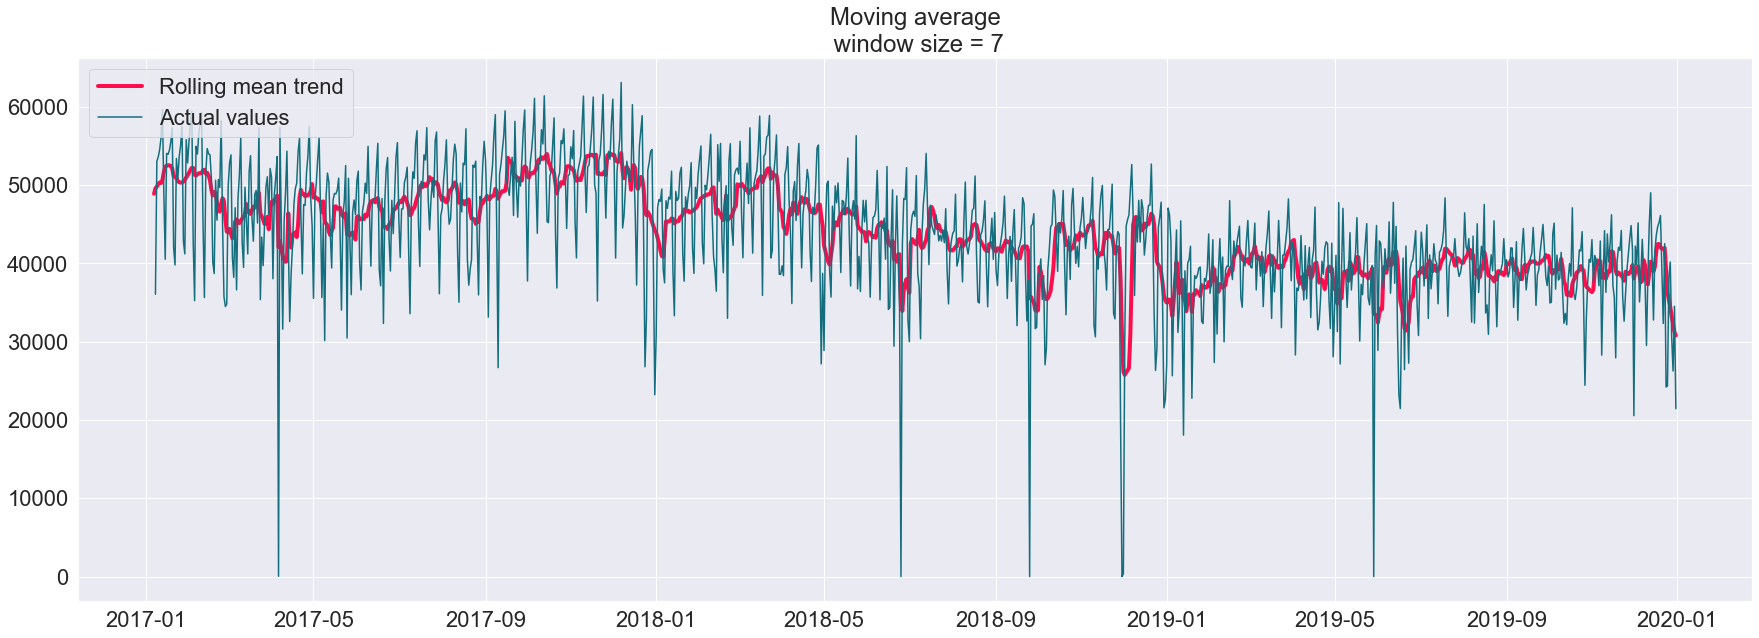

In [12]:
plotMovingAverage(u.cantidad_pasos, 7) 

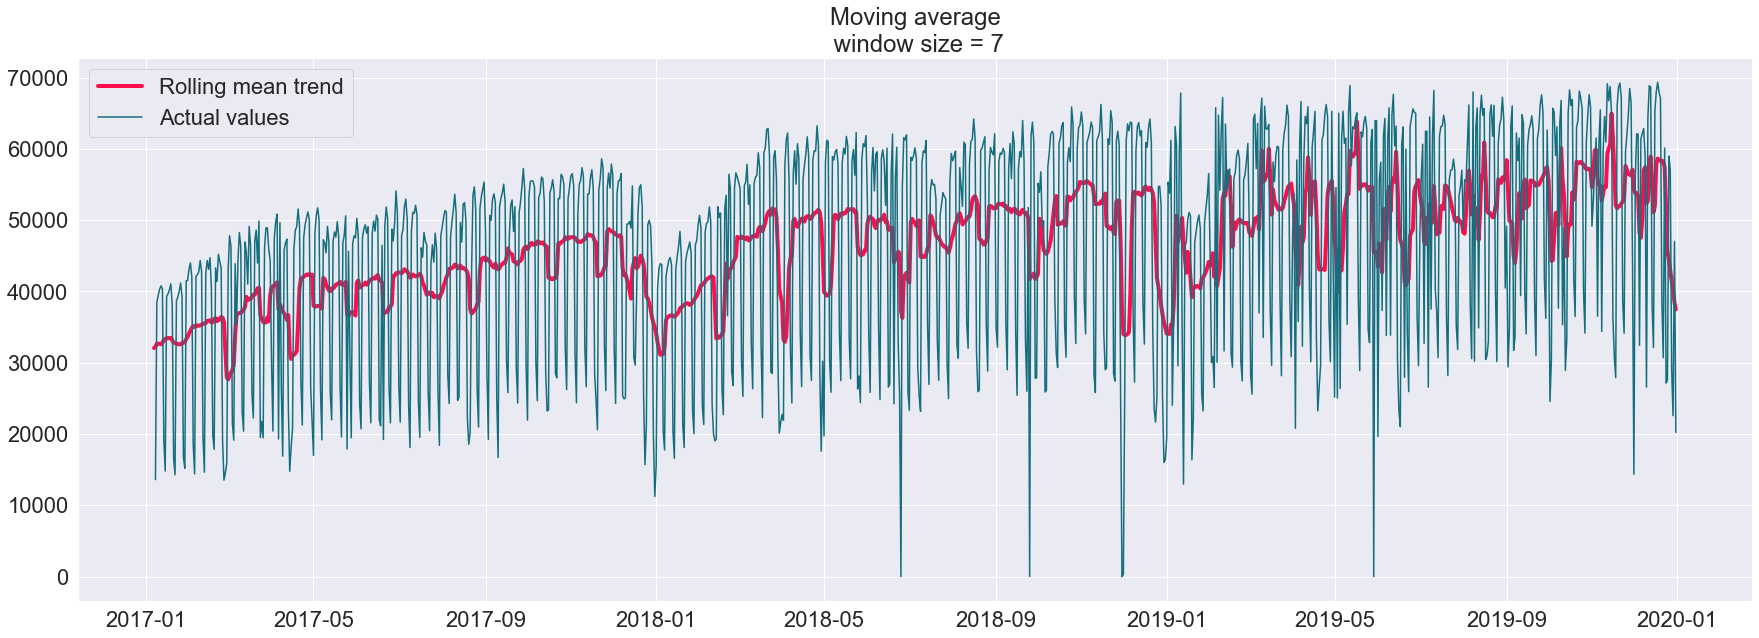

In [13]:
plotMovingAverage(w.cantidad_pasos, 7) 

Datos suvizados con una ventana de 7 días.

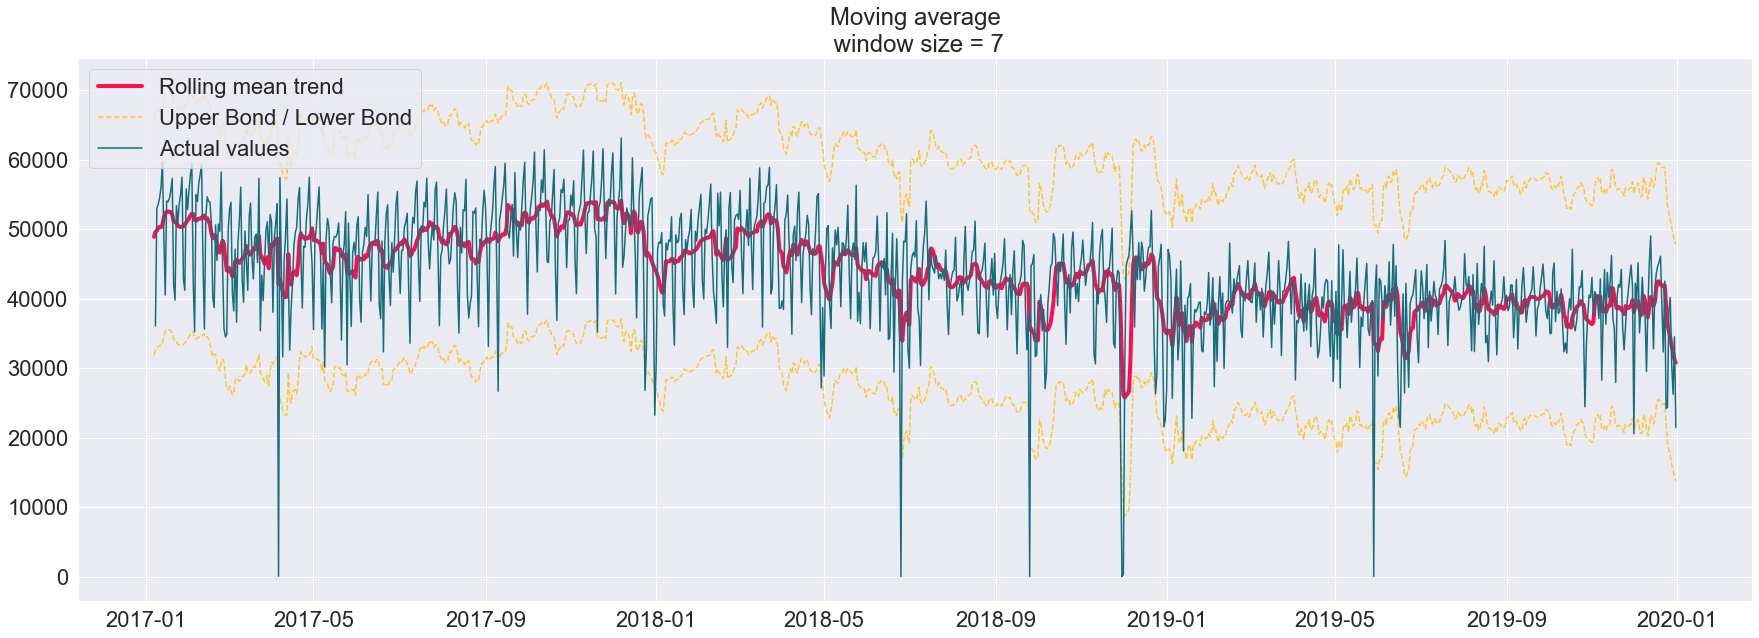

In [14]:
plotMovingAverage(u.cantidad_pasos, 7, plot_intervals=True)

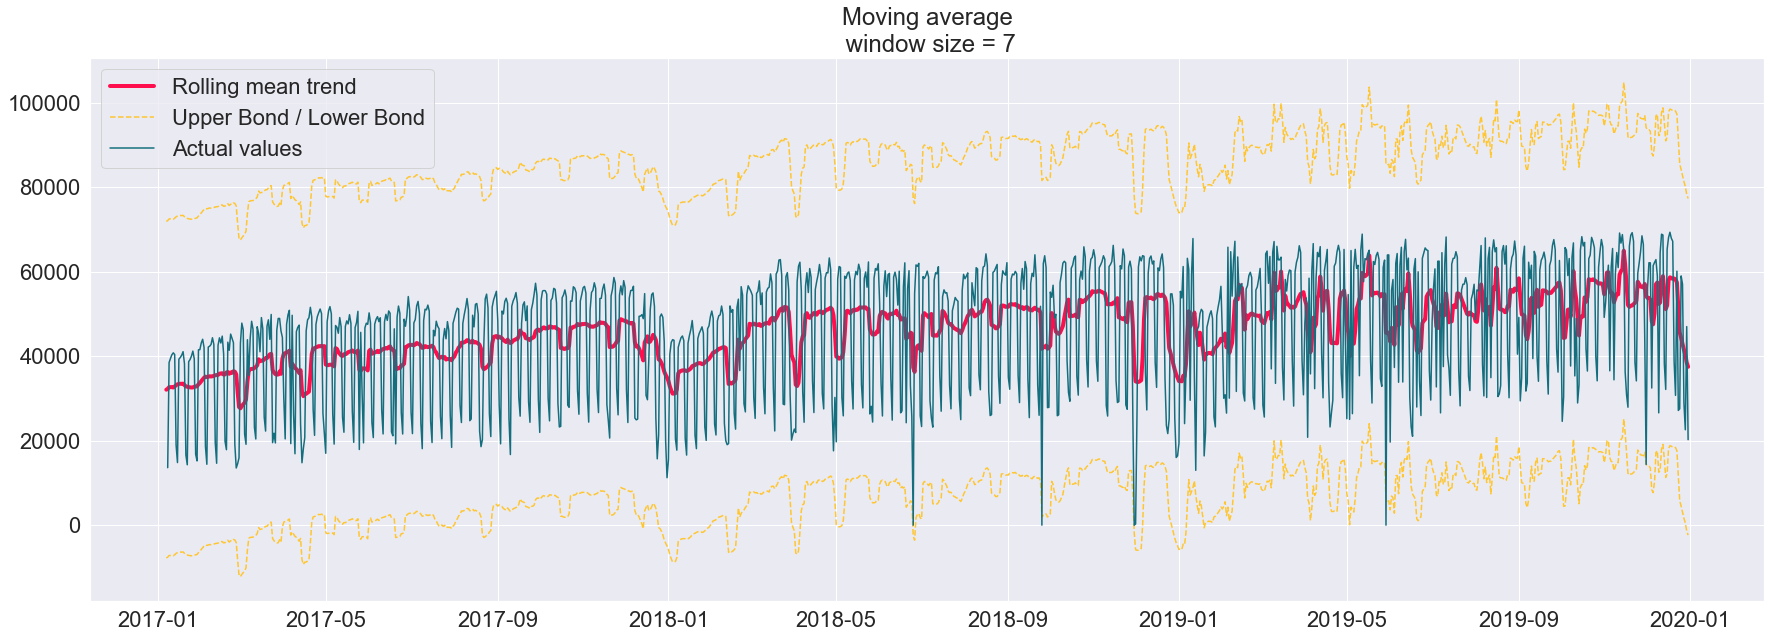

In [15]:
plotMovingAverage(w.cantidad_pasos, 7, plot_intervals=True)

Se muestra en amarillo el intervalo de confianza, el cual nos permite dectectar valores atípicos.

Ahora, creemos un sistema de detección de anomalías simple con la ayuda de la media móvil.

In [16]:
d_anomaly = pd.DataFrame(u.cantidad_pasos)
d_anomaly
d_anomaly.iloc[-20] = d_anomaly.iloc[-20] * 0.2
d_anomaly2 = pd.DataFrame(w.cantidad_pasos)
d_anomaly2
d_anomaly2.iloc[-20] = d_anomaly2.iloc[-20] * 0.2

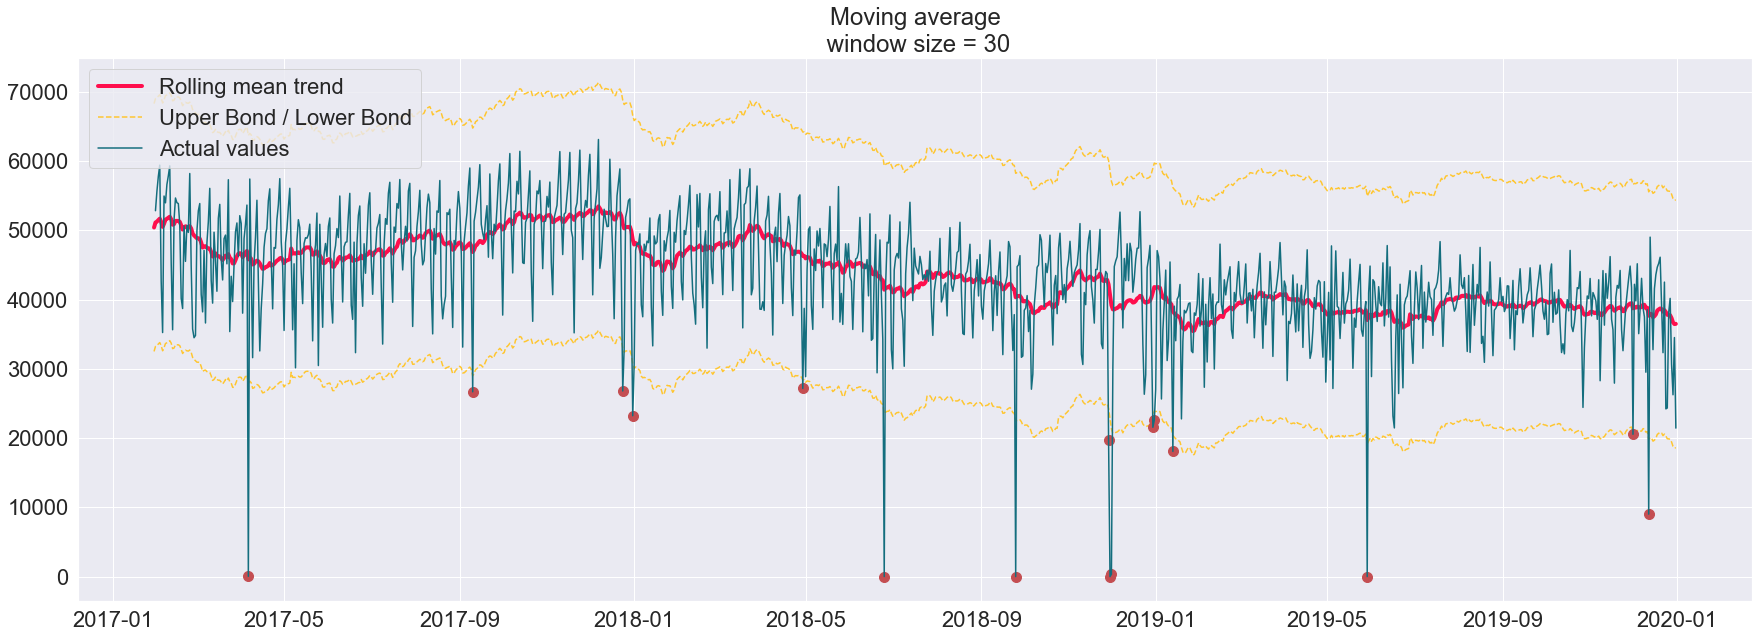

In [17]:
plotMovingAverage(d_anomaly, 30, plot_intervals=True, plot_anomalies=True)


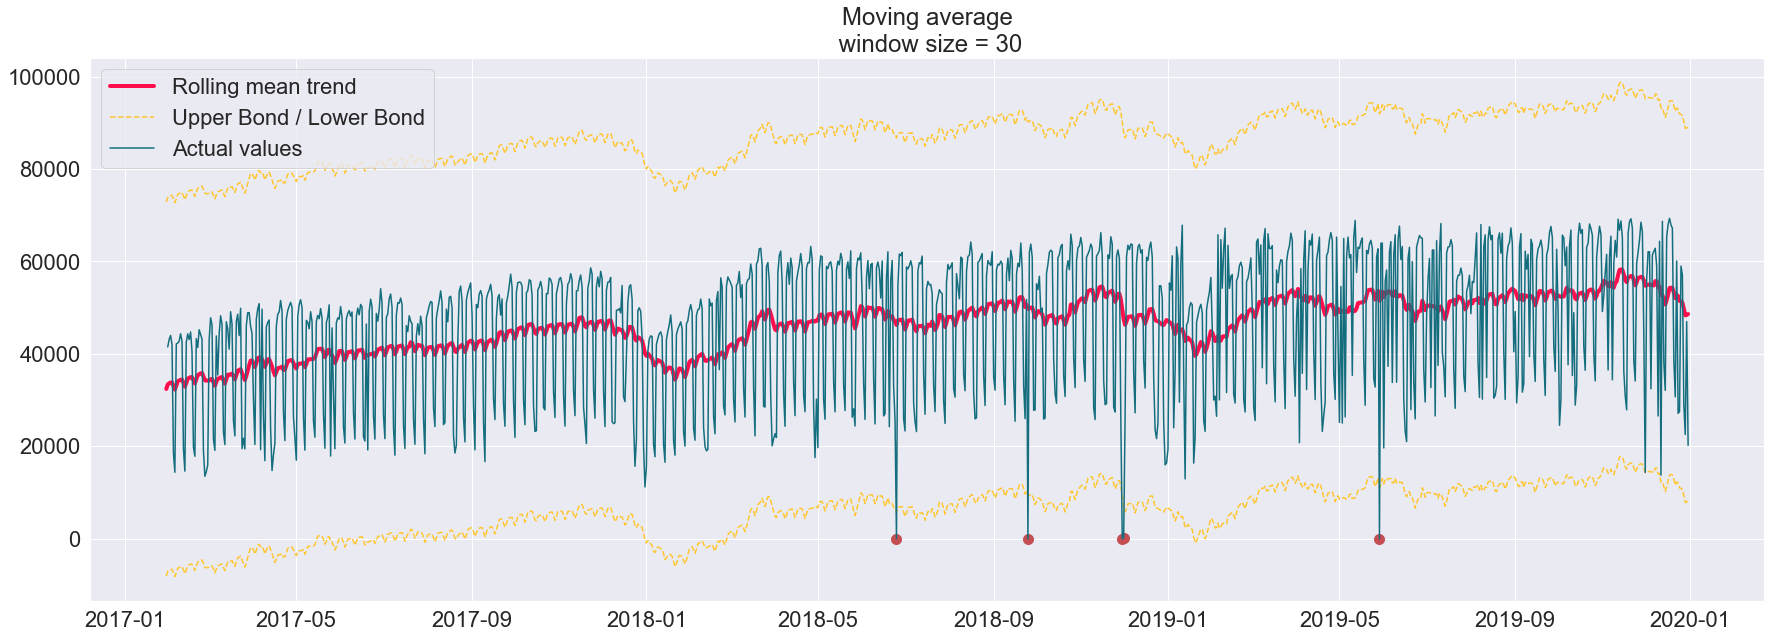

In [18]:
plotMovingAverage(d_anomaly2, 30, plot_intervals=True, plot_anomalies=True)

Con una ventana de 30 días obtenemos en rojos los datos atípicos que no deberian estar.

In [19]:
#Se define el filtro Hampel
def hampel_filter_forloop(input_series, window_size, n_sigmas=4):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices


In [20]:
res, detected_outliers = hampel_filter_forloop(u.cantidad_pasos, 7)
u['cantidad_pasos_filtro'] = res
res, detected_outliers = hampel_filter_forloop(w.cantidad_pasos, 7)
w['cantidad_pasos_filtro'] = res

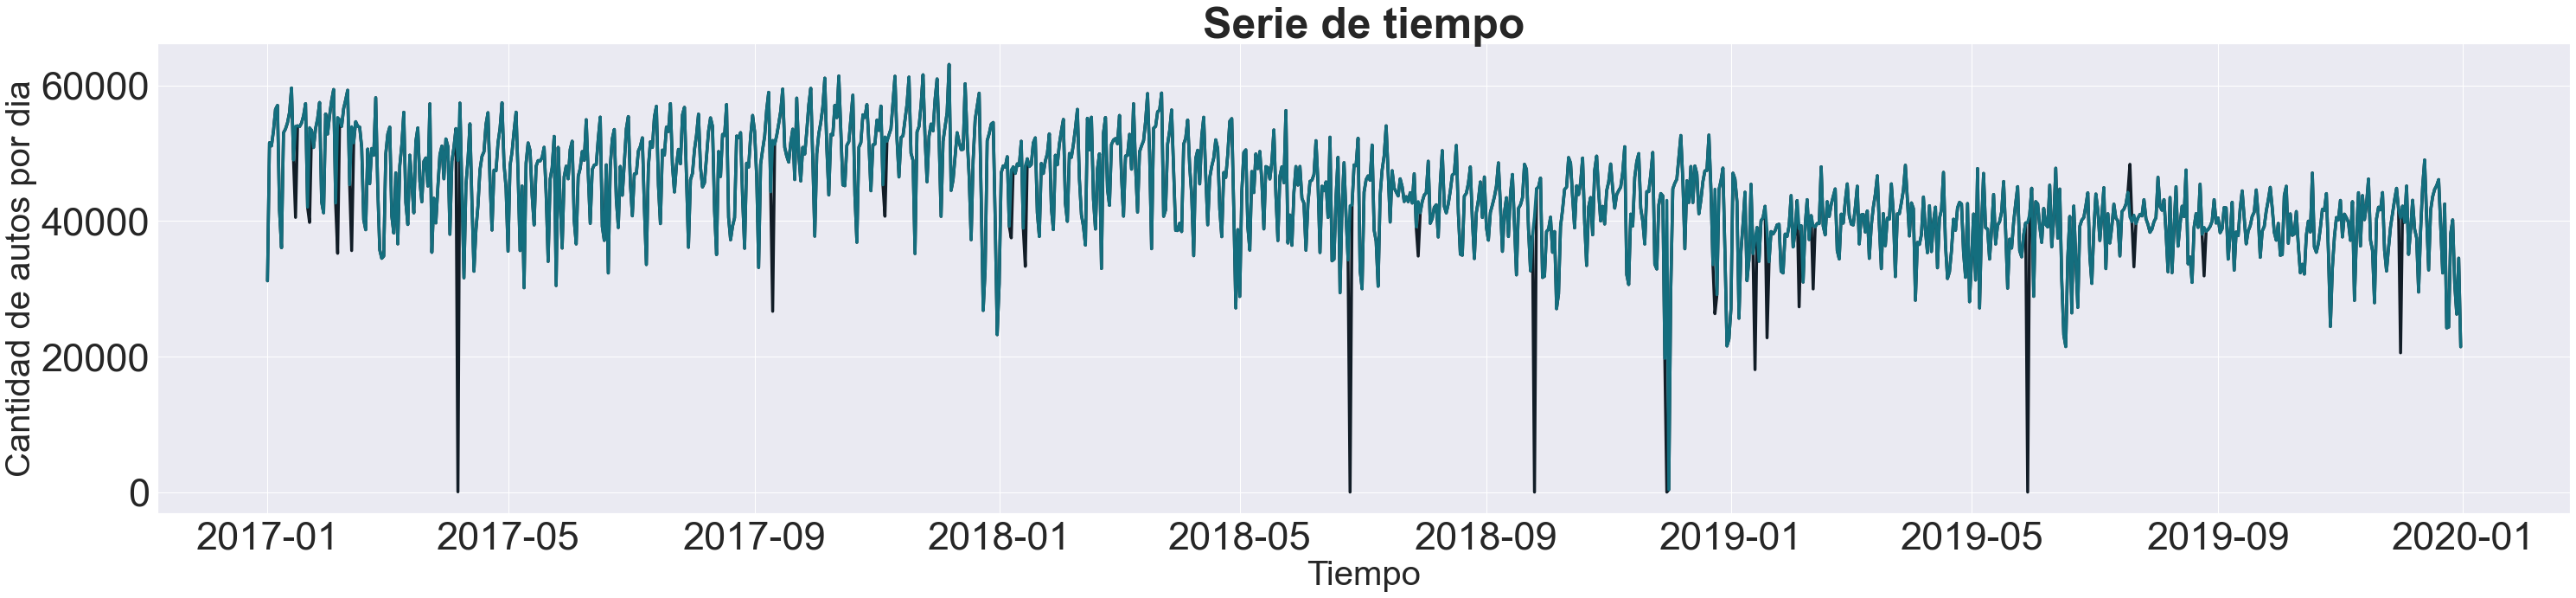

In [21]:
plt.figure(figsize=(50,10));
sns.set(font_scale=4.1)
sns.lineplot( x=u.index, y=u.cantidad_pasos, color = c1,lw = 3.5 );
sns.lineplot( x=u.index, y=u.cantidad_pasos_filtro, color = c3,lw = 3.5 );
plt.grid(True);
plt.xlabel('Tiempo',fontsize = 40)
plt.title('Serie de tiempo', fontsize =50, fontweight = "bold")
plt.ylabel('Cantidad de autos por dia',fontsize = 40);


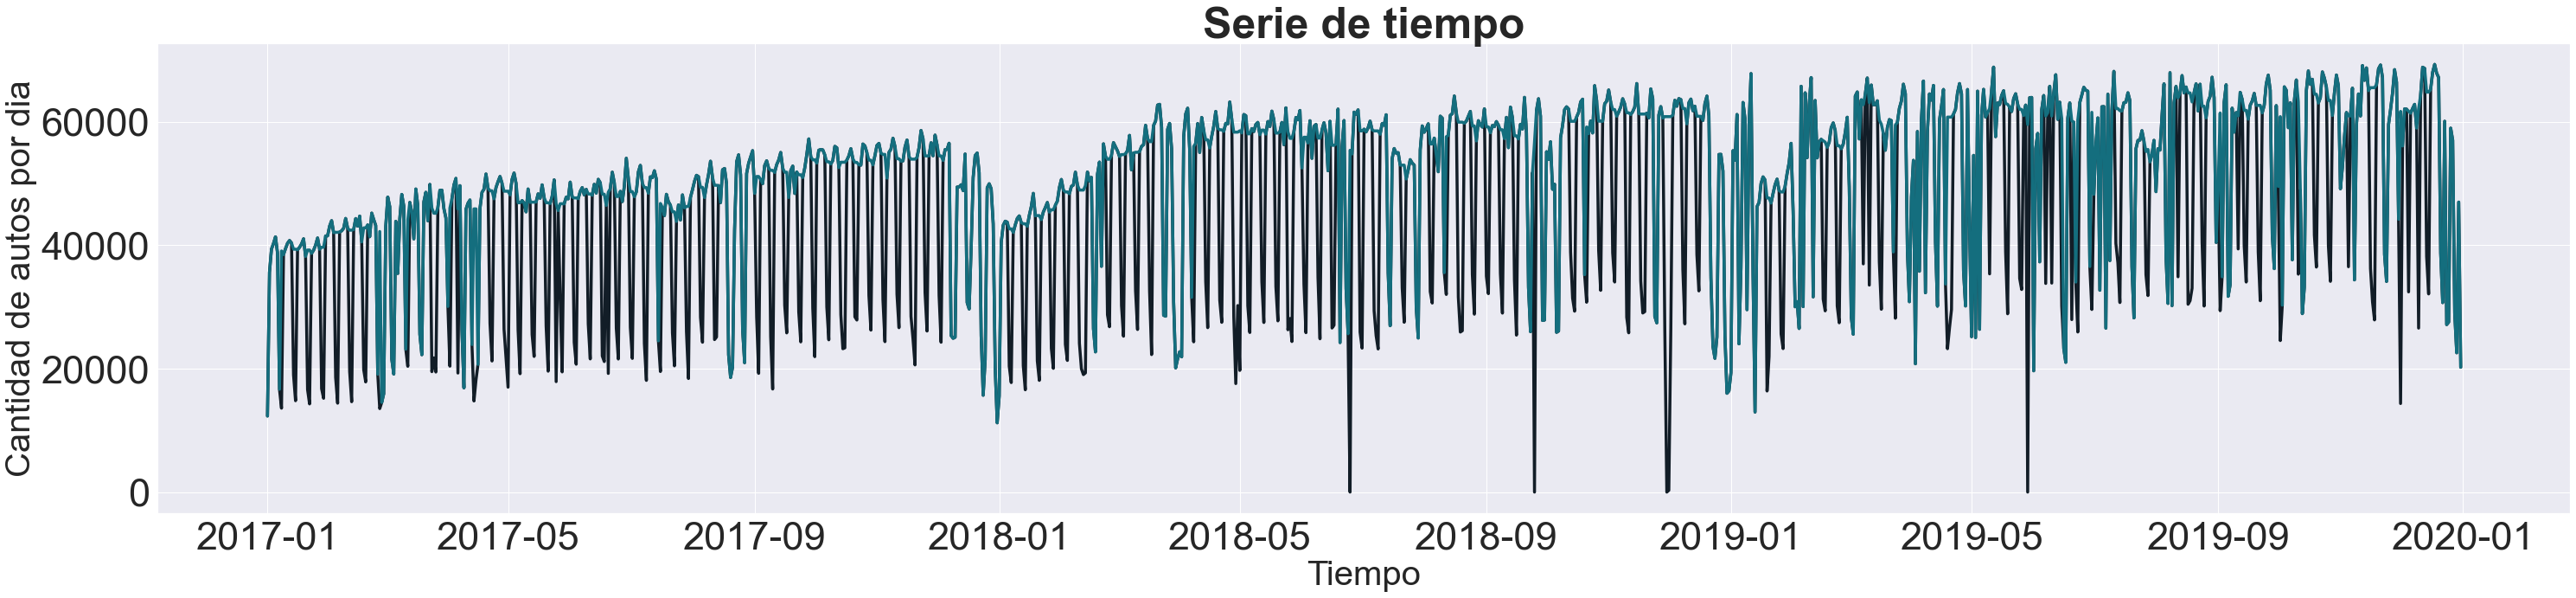

In [22]:
plt.figure(figsize=(50,10));
sns.set(font_scale=4.1)
sns.lineplot( x=w.index, y=w.cantidad_pasos, color = c1,lw = 3.5 );
sns.lineplot( x=w.index, y=w.cantidad_pasos_filtro, color = c3,lw = 3.5 );
plt.grid(True);
plt.xlabel('Tiempo',fontsize = 40)
plt.title('Serie de tiempo', fontsize =50, fontweight = "bold")
plt.ylabel('Cantidad de autos por dia',fontsize = 40);


## Suavizado exponencial
Ahora, veamos qué sucede si, en lugar de ponderar los últimos ``k`` valores de la serie de tiempo, comenzamos a ponderar todas las observaciones disponibles mientras disminuimos exponencialmente el peso de los coeficientes de la media a medida que retrocedemos en el tiempo. Existe una fórmula para el suavizado exponencial que nos ayudará con esto:
\begin{equation}
y_t = \alpha y_t+(1-\alpha)y_{t-1}
\end{equation}
 
Aquí, el valor del modelo es un promedio ponderado entre el valor real actual y los valores del modelo anterior. El peso $\alpha$ se denomina factor de suavizado. Define la rapidez con la que "olvidaremos" la última observación verdadera disponible. Cuanto menor sea $\alpha$, mayor influencia tendrán las observaciones anteriores y más suave será la serie.

La exponencialidad está oculta en la recursividad de la función: multiplicamos por (1 − $\alpha$) cada vez, que ya contiene una multiplicación por (1 −$\alpha$) de los valores del modelo anterior.

In [23]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [24]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    sns.set(font_scale=2.1)
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(35, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha),lw=4,color=c2)
        plt.plot(series.values, "c", label = "Actual",lw=2,color=c5)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

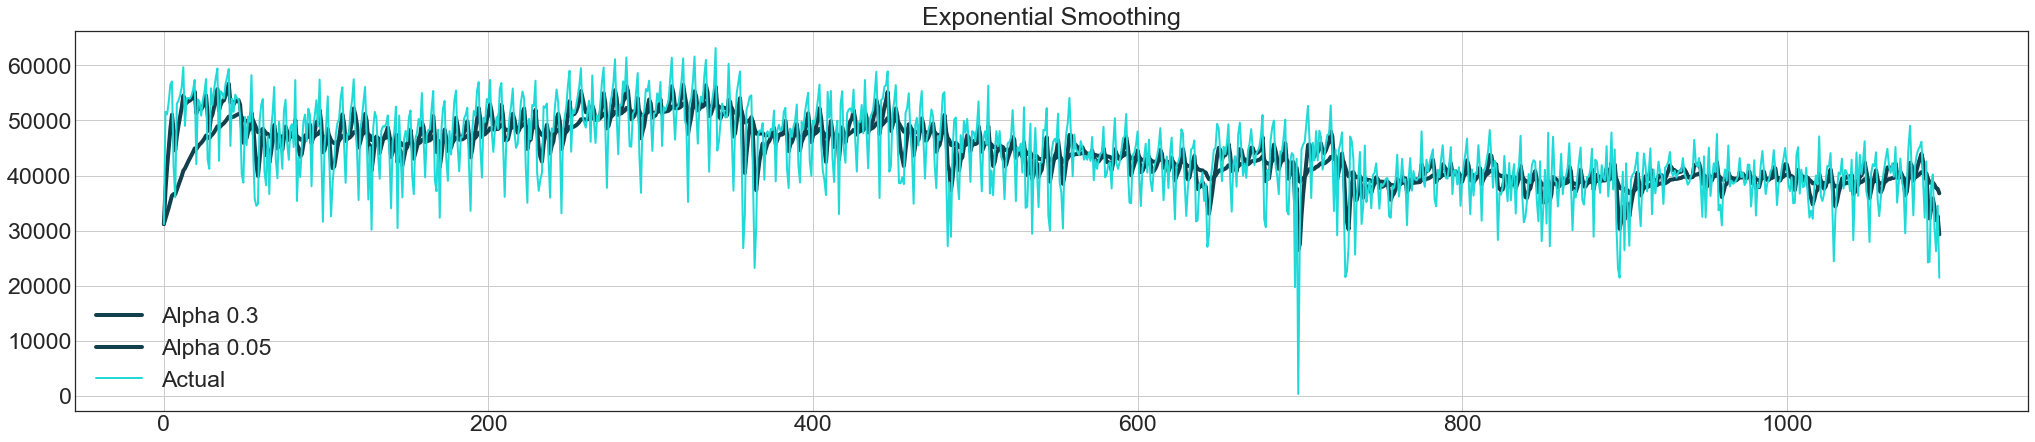

In [25]:
plotExponentialSmoothing(u.cantidad_pasos_filtro, [0.3, 0.05])

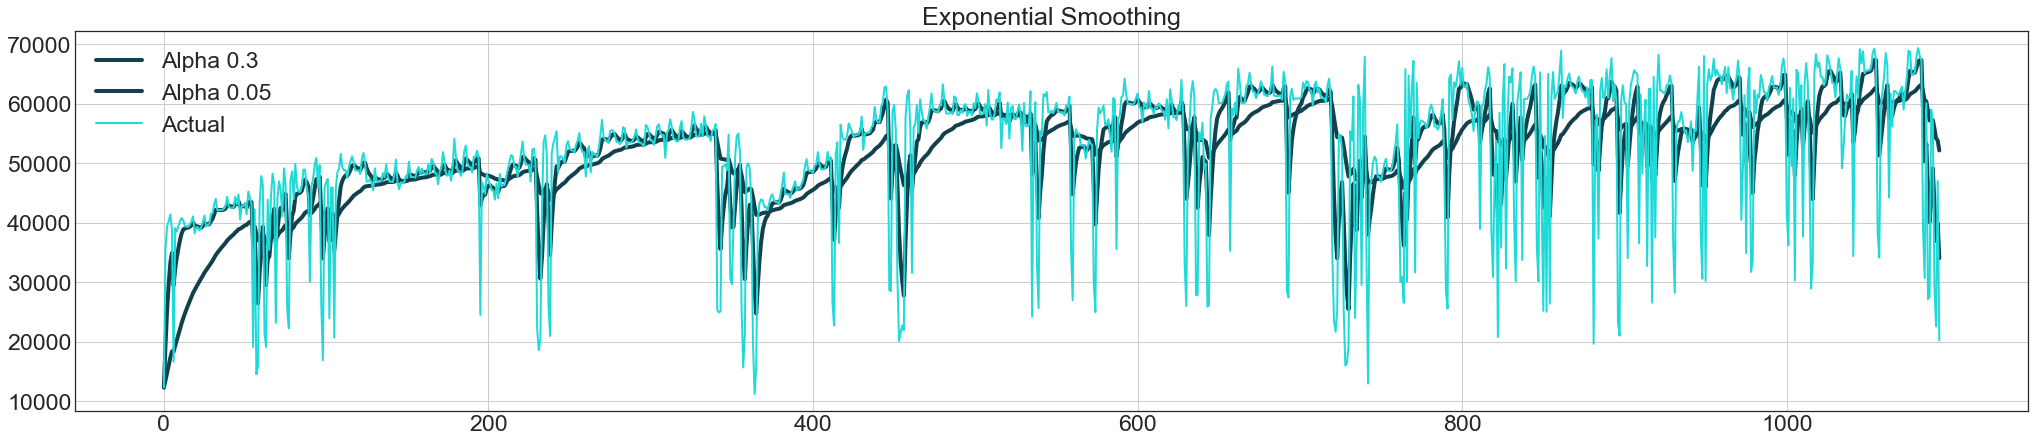

In [26]:
plotExponentialSmoothing(w.cantidad_pasos_filtro, [0.3, 0.05])

## Suavizado exponencial doble
Hasta ahora, los métodos que se han discutido han sido para una predicción de un único punto futuro (con un buen suavizado). Eso es genial, pero tampoco es suficiente. Extendamos el suavizado exponencial para que podamos predecir dos puntos futuros (por supuesto, también incluiremos más suavizado).

La descomposición en serie nos ayudará: obtenemos dos componentes: intersección (es decir, nivel) `l` y pendiente (es decir, tendencia) `b`. Hemos aprendido a predecir la intersección (o el valor esperado de la serie) con nuestros métodos anteriores; ahora, aplicaremos el mismo suavizado exponencial a la tendencia asumiendo que la dirección futura de los cambios de la serie temporal depende de los cambios ponderados anteriores. Como resultado, obtenemos el siguiente conjunto de funciones:

\begin{equation}
l_x=\alpha y_x+(1-\alpha)(l_{x-1}+b_{x-1})\\
b_x =\beta(l_x−l_{x-1})+(1−\beta)b_{x-1}\\
y_{x+1}=l_x+b_x
\end{equation}

 
El primero describe la intersección, que, como antes, depende del valor actual de la serie. El segundo término ahora se divide en valores anteriores del nivel y de la tendencia. La segunda función describe la tendencia, que depende de los cambios de nivel en el paso actual y del valor anterior de la tendencia. En este caso, el coeficiente $\beta$ es un peso para el suavizado exponencial. La predicción final es la suma de los valores del modelo de la intersección y la tendencia.

In [27]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

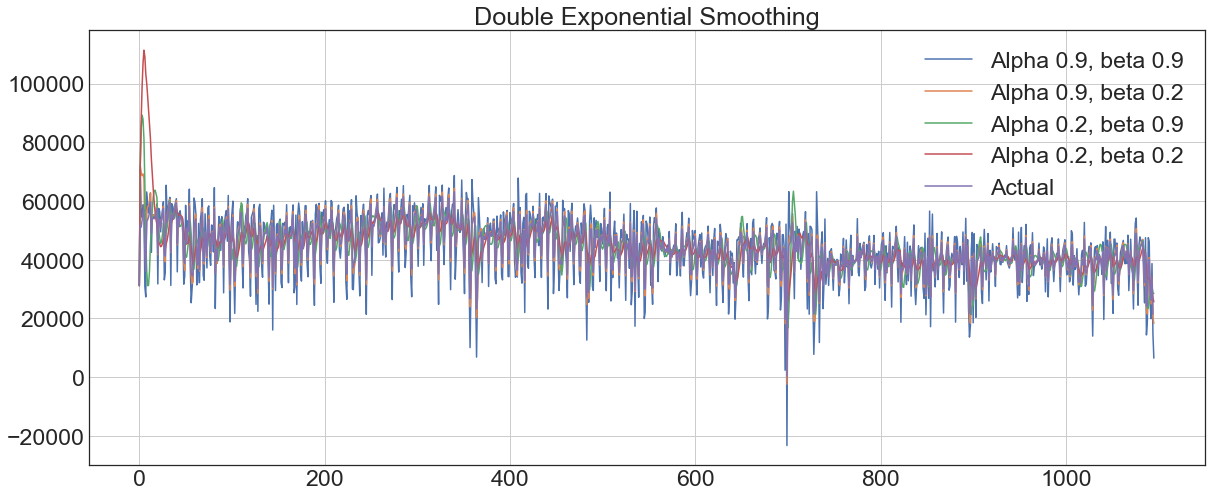

In [28]:
plotDoubleExponentialSmoothing(u.cantidad_pasos_filtro, alphas=[0.9, 0.2], betas=[0.9, 0.2])

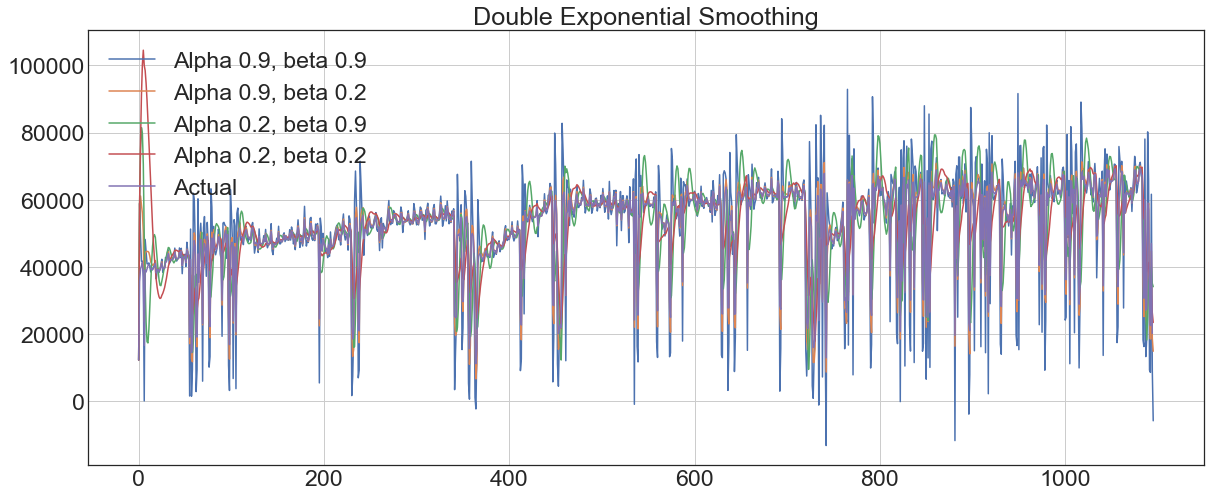

In [29]:
plotDoubleExponentialSmoothing(w.cantidad_pasos_filtro, alphas=[0.9, 0.2], betas=[0.9, 0.2])

Ahora tenemos que ajustar dos parámetros: $\alpha$ y $\beta$. El primero es responsable del suavizado de la serie alrededor de la tendencia, el segundo del suavizado de la tendencia en sí. Cuanto mayores sean los valores, más peso tendrán las observaciones más recientes y menos suavizada será la serie del modelo. Ciertas combinaciones de parámetros pueden producir resultados extraños, especialmente si se configuran manualmente. Veremos cómo elegir parámetros automáticamente en un momento; antes de eso, analicemos el suavizado exponencial triple.

<a id="s-21"></a>
## Suavizado triple exponencial p Holt-Winters
Se ha analizado el suavizado exponencial y el suavizado exponencial doble. Esta vez, entraremos en un suavizado exponencial triple.

La idea es agregar un tercer componente: la estacionalidad. Esto significa que no debemos utilizar este método si no se espera que nuestra serie temporal tenga estacionalidad. Los componentes estacionales en el modelo explicarán las variaciones repetidas alrededor de la intersección y la tendencia, y se especificarán por la duración de la temporada, en otras palabras, por el período después del cual se repiten las variaciones. Para cada observación en la temporada, hay un componente separado; por ejemplo, si la duración de la temporada es de ``7`` días (una estacionalidad semanal), tendremos ``7 ``componentes estacionales, uno para cada día de la semana. 
El modelo implementado lo puede revisar en detalle [aqui](https://mlcourse.ai/articles/topic9-part1-time-series/#4.-Linear-(and-not-quite)

In [30]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [31]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

### Validación cruzada de series de tiempo
Antes de comenzar a construir un modelo, primero analicemos debemos encontrar los parámetros óptimos para el modelo de Holt-Winters. Recuerde que tenemos la estacionalidad diaria en los anuncios, de ahí el parámetro ``slen = 7``. Revisar el proyecto 3 o la siguiente sección donde hablo de este resultado.

In [32]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

En el modelo de ``Holt-Winters``, así como en los otros modelos de suavizado exponencial, existe una restricción sobre el tamaño de los parámetros de suavizado, cada uno de ellos en un rango de ``0 a 1``. Por lo tanto, para minimizar nuestra función de pérdida, tiene que elegir un algoritmo que admita restricciones en los parámetros del modelo. En nuestro caso, usaremos el ``gradiente conjugado de Newton truncado``.

In [33]:
%%time
data = u.cantidad_pasos_filtro[:-7] # datos de prueba (un mes atras)

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 30 day
model = HoltWinters(data, slen = 7, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 30, scaling_factor = 5)
model.triple_exponential_smoothing()

0.01142649789911887 0.014710730001386452 0.015313571092895994
Wall time: 16.7 s


In [34]:
def plotHoltWinters(series, plot_intervals=True, plot_anomalies=True):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model",color =c8)
    plt.plot(series.values, label = "Actual",color=c6)
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies",color='r')
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-5, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

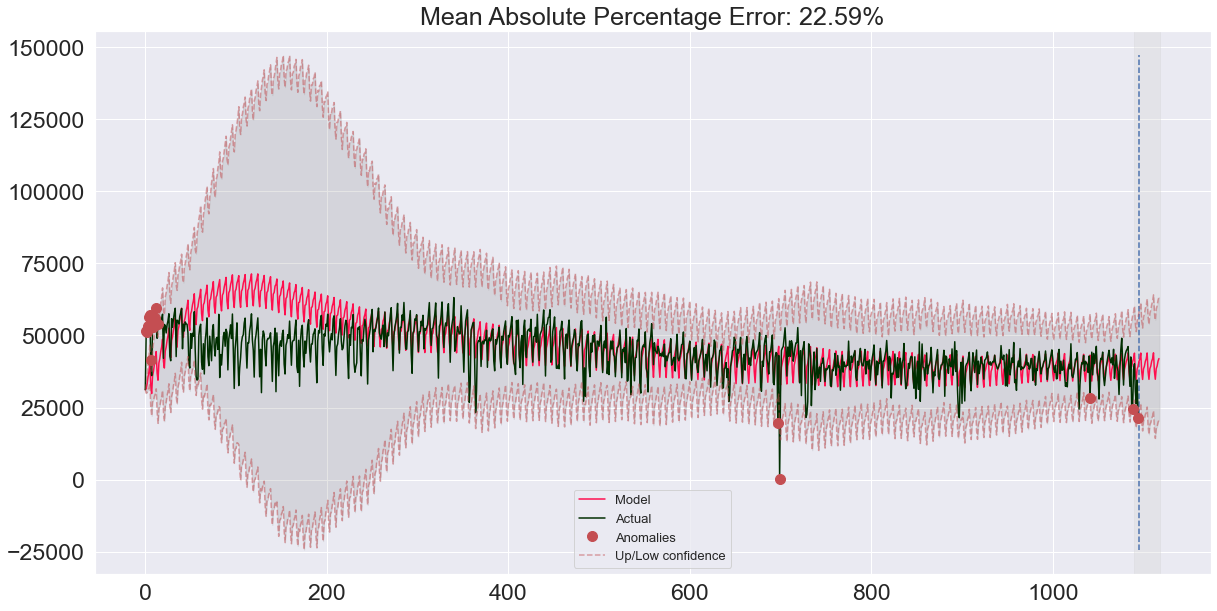

In [35]:
plotHoltWinters(u.cantidad_pasos_filtro)

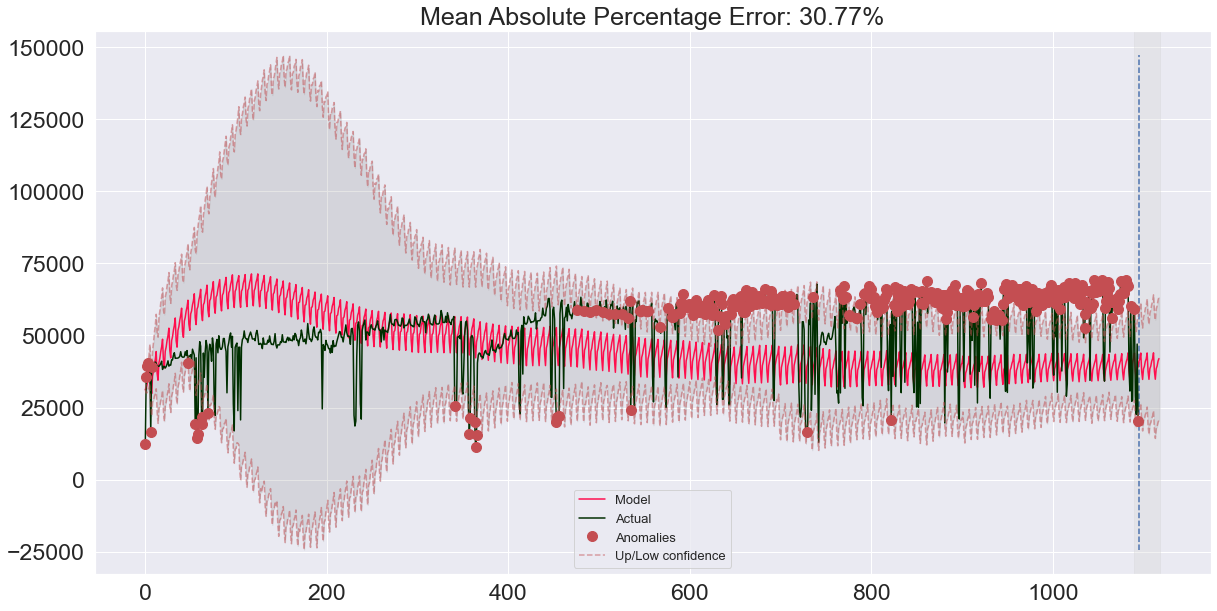

In [36]:
plotHoltWinters(w.cantidad_pasos_filtro)

A juzgar por las gráficas, nuestro modelo pudo aproximarse con éxito a la serie de tiempo medio, capturando la estacionalidad diaria, la tendencia general a la baja e incluso algunas anomalías. Si observa las desviaciones del modelo, puede ver claramente que el modelo reacciona de manera bastante brusca a los cambios en la estructura de la serie, pero luego devuelve rápidamente la desviación a los valores normales, esencialmente "olvidando" el pasado. Esta característica del modelo nos permite construir rápidamente sistemas de detección de anomalías, incluso para datos en serie ruidosos, sin gastar demasiado tiempo y dinero en preparar los datos y entrenar el modelo.

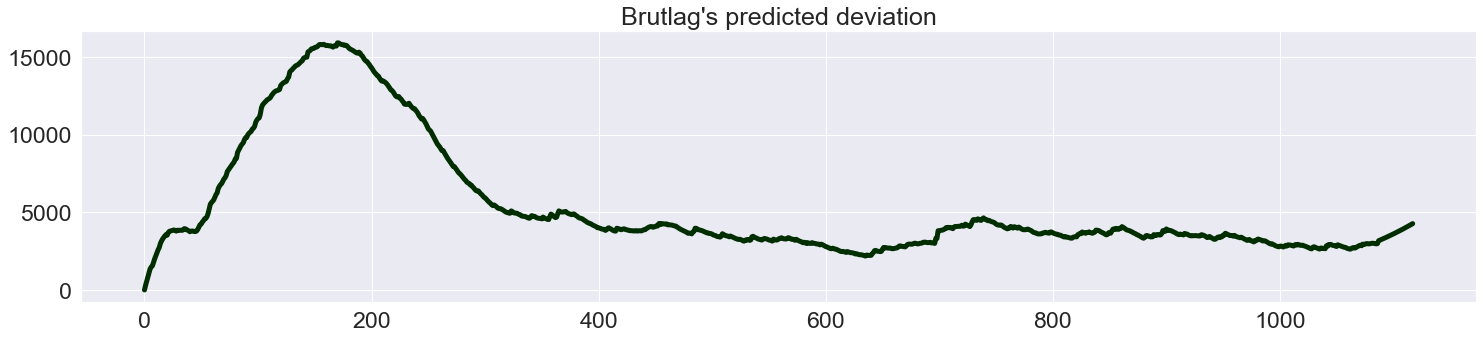

In [37]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation, color=c6,lw=5)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

<a id="s-22"></a>
# Modelamiento
## Estacionariedad

Antes de comenzar a modelar, debemos mencionar una propiedad tan importante de las series de tiempo: la estacionariedad.

Si un proceso es estacionario, eso significa que no cambia sus propiedades estadísticas con el tiempo, es decir, su media y varianza. (La constancia de la varianza se llama homocedasticidad). La función de covarianza no depende del tiempo; solo debería depender de la distancia entre observaciones.

In [38]:
def tsplot(y, lags=None, figsize=(20, 15), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

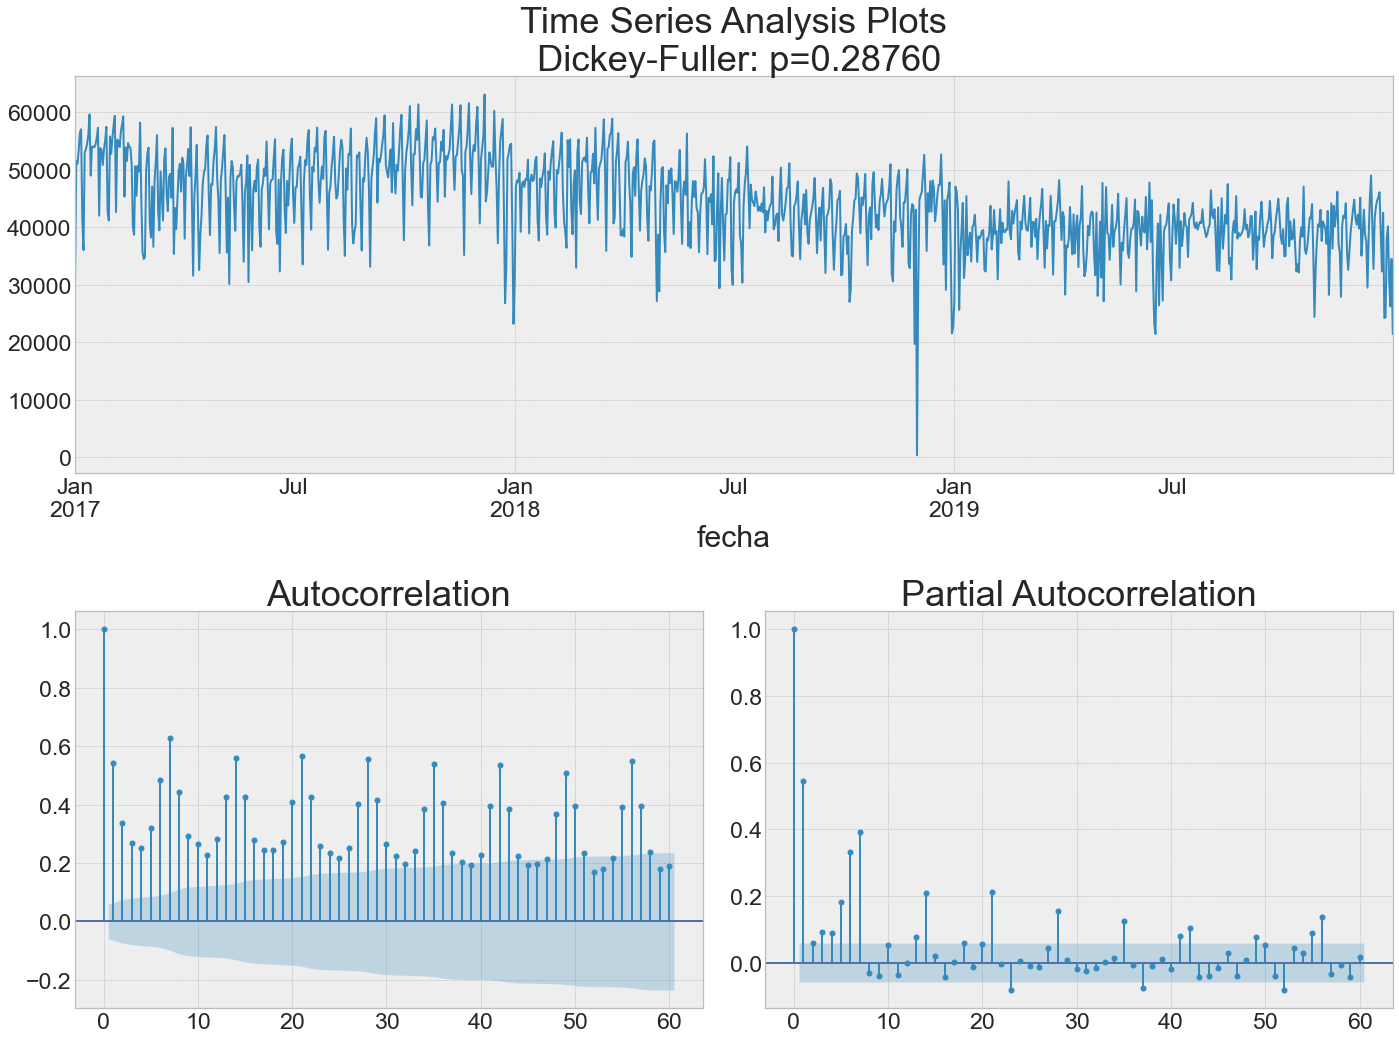

In [39]:
tsplot(u.cantidad_pasos_filtro, lags=60)

Por la prueba de hipotesis de Dicker-Fuller, obtenemos que la serie de ``Illia`` con medio de pago en efectivo es no estacionaria. Por lo cual se procede a hacerla estacionaria por el método de diferenciación. En el proyecto anterior se explico en detalle este paso, por tanto se expera que el lector lo revise.

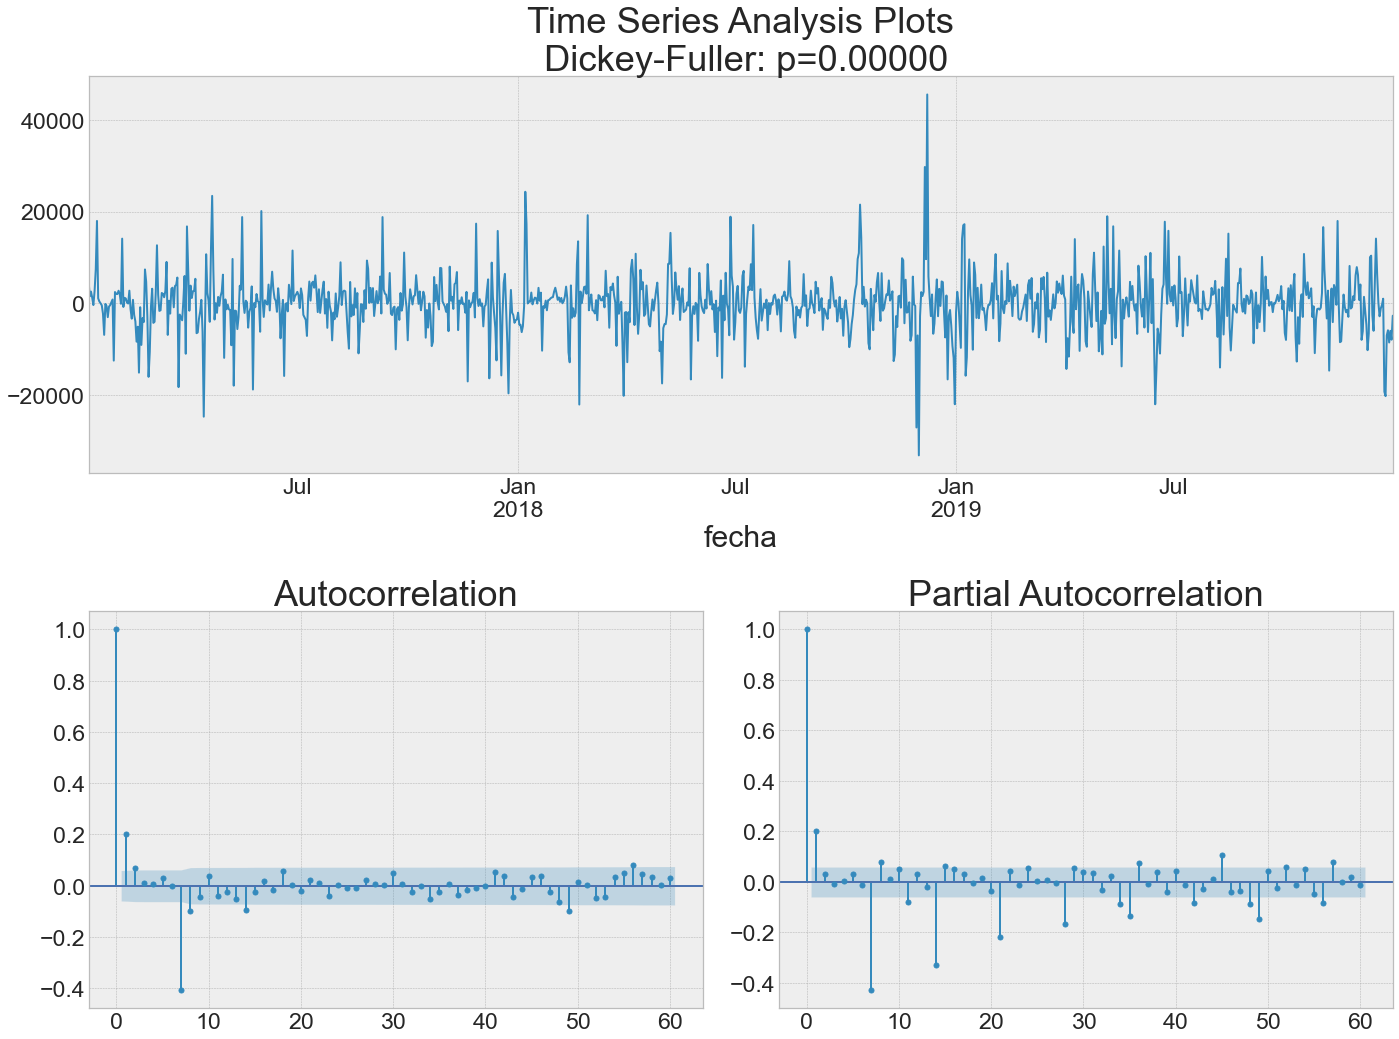

In [40]:
ads_diff = u.cantidad_pasos_filtro - u.cantidad_pasos_filtro.shift(7)
tsplot(ads_diff[7:], lags=60)

Perfecto! Nuestra serie ahora parece algo indescriptible, oscilando alrededor de cero. La prueba de Dickey-Fuller indica que está estacionaria y que ha disminuido el número de picos significativos en ACF. ¡Por fin podemos empezar a modelar ``SARIMA``.

<a id="s-23"></a>
# SARIMA 

SARIMA (p, d, q) (P, D, Q, s) es un modelo de media móvil de autorregresión estacional donde:

``AR (p)``: modelo de autorregresión, es decir, regresión de la serie de tiempo sobre sí misma. El supuesto básico es que los valores de la serie actual dependen de sus valores anteriores con algún rezago (o varios rezagos). El retraso máximo en el modelo se denomina p. Para determinar la p inicial, debe observar el gráfico ``PACF`` y encontrar el mayor retraso significativo después del cual la mayoría de los demás retrasos se vuelven insignificantes.

``MA (q)``: modelo de media móvil. Sin entrar en demasiados detalles, modela el error de la serie temporal, nuevamente con el supuesto de que el error actual depende del anterior con cierto rezago, lo que se denomina q. El valor inicial se puede encontrar en el gráfico ACF con la misma lógica que antes.
Combinemos nuestras primeras 4 letras:

``AR (p) + MA (q) = ARMA (p, q)``
Lo que tenemos aquí es el modelo de media móvil autorregresiva. Si la serie es estacionaria, se puede aproximar con estas 4 letras. Continuemos.

``I (d)`` : orden de integración. Este es simplemente el número de diferencias no estacionales necesarias para que la serie sea estacionaria. En nuestro caso, es solo 1 porque usamos primeras diferencias.
La adición de esta letra a las cuatro nos da el modelo ARIMA que puede manejar datos no estacionarios con la ayuda de diferencias no estacionales.

``S (s)``: esto es responsable de la estacionalidad e iguala la duración del período de temporada de la serie
Con esto, tenemos tres parámetros: (P, D, Q)
``P`` - orden de autorregresión para el componente estacional del modelo, que puede derivarse de PACF. Pero debe observar la cantidad de retrasos significativos, que son los múltiplos de la duración del período de la temporada. Por ejemplo, si el período es igual a 7 y vemos que los rezagos 7 y 14 son significativos en el ``PACF``, eso significa que la ``P`` inicial debería ser 2.

``Q`` - lógica similar usando la gráfica ``ACF`` en su lugar.

``D`` - orden de integración estacional. Esto puede ser igual a 1 o 0, dependiendo de si se aplicaron o no diferencias estacionales.

Ahora que sabemos cómo establecer los parámetros iniciales, echemos un vistazo al gráfico final una vez más y establezcamos los parámetros:

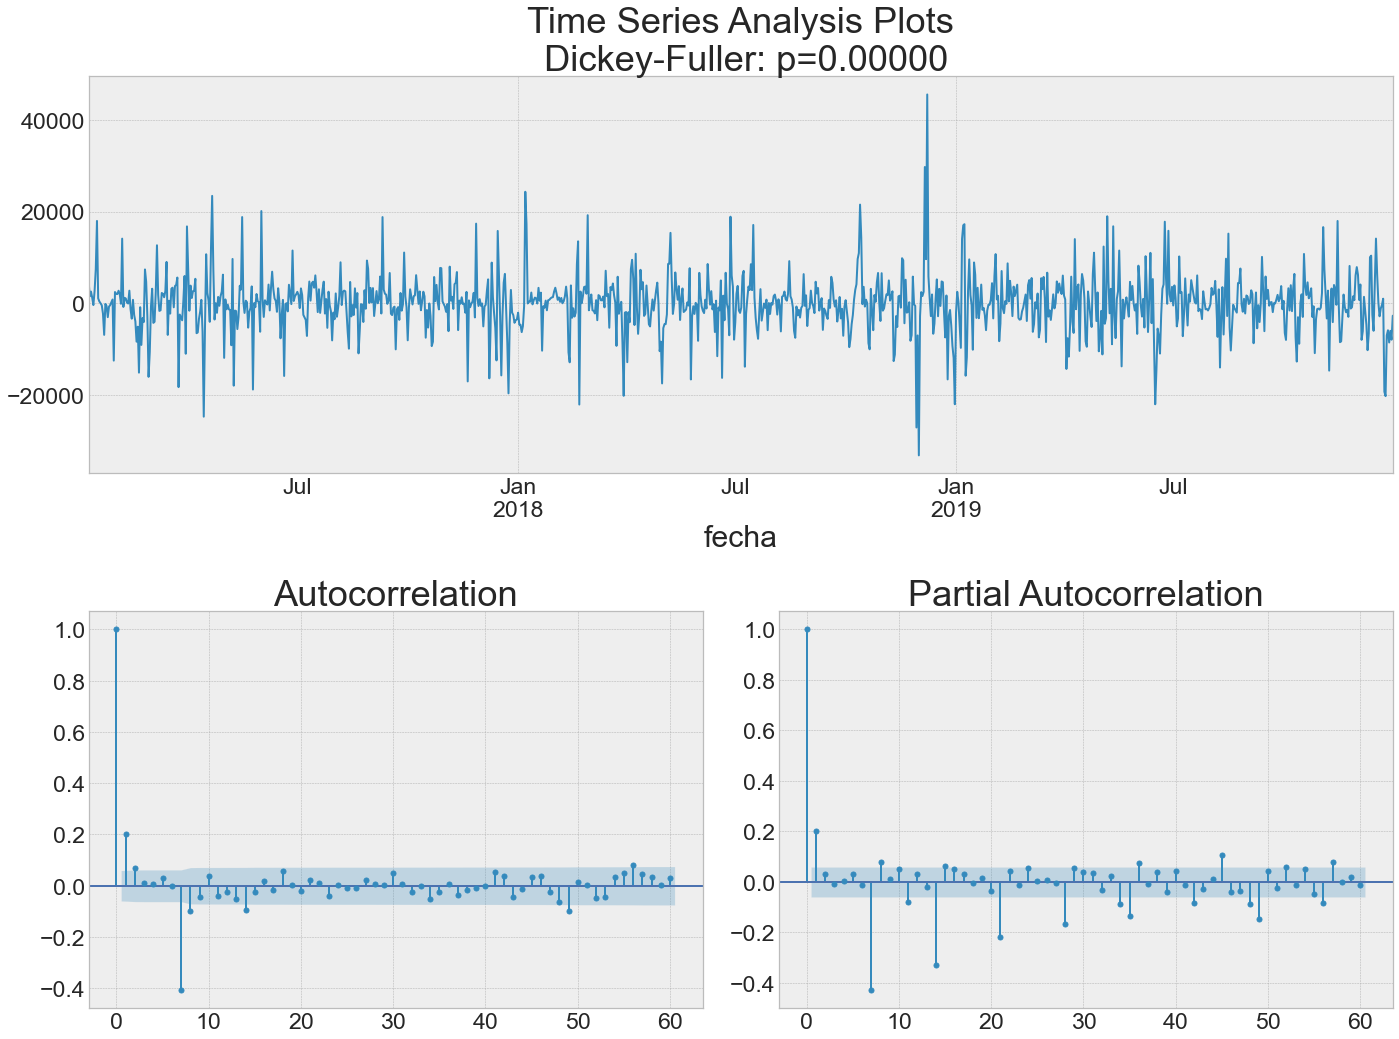

In [41]:
tsplot(ads_diff[7:], lags=60)

**p**: es probable sea 7 ya que es el último rezago significativo en el PACF, después del cual, la mayoría de los demás no son significativos.

**d**: es igual a 1 porque tuvimos las primeras diferencias.

**q**: debe estar en algún lugar alrededor de 7, así como se ve en el ACF.

**P**: podría ser 2, ya que los retrasos 7 y 14 son algo significativos en el PACF.

**D**: nuevamente es igual a 1 porque realizamos la diferenciación estacional.

**Q**: es probablemente 1. El desfase 7 en ACF es significativo, mientras que el 14 no lo es.

In [42]:
# setting initial values and some bounds for them
ps = range(5, 8)
d=1 
qs = range(0, 4)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is still 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)  #

48

In [43]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(u.cantidad_pasos_filtro, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [44]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 1min 52s


In [45]:
result_table.head()

parameters           aic
0  (5, 1, 0, 1)  21647.416281
1  (6, 3, 0, 1)  21673.123829
2  (7, 3, 0, 1)  21674.720566
3  (6, 3, 1, 1)  21678.778108
4  (5, 3, 0, 1)  21691.390920

In [46]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(u.cantidad_pasos_filtro, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:             cantidad_pasos_filtro   No. Observations:                 1095
Model:             SARIMAX(5, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -10815.708
Date:                           Fri, 19 Mar 2021   AIC                          21647.416
Time:                                   23:14:24   BIC                          21687.346
Sample:                               01-01-2017   HQIC                         21662.531
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5188      0.072    -21.067      0.000      -1.660      -1.377
ar.L2         -0.9215      0.055    -16.853

La tabla resumen nos indica que todos los coeficientes son significativos, ps su p-valor es nulo, por lo cual los parámetros encontrados nos pueden dar un buen modelo.

In [47]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    sns.set(font_scale=1)

    rc('text', usetex=False)
    rc('font', family='serif')
    data = series.copy()
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['cantidad_pasos_filtro'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, label="model",color = c2)
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.cantidad_pasos_filtro, label="actual",color =c8)
    plt.legend()
    plt.grid(True)

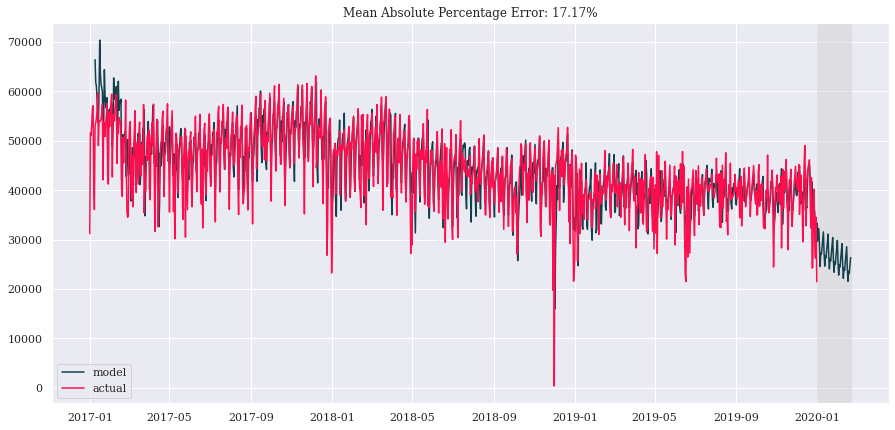

In [48]:
plotSARIMA(u, best_model, 50)

Efectivamente, hemos tenido un error del 17.17% lo cual es inferior al modelo base con el cual arrancamos. A continuación realizamos el mismo procedimiento para la serie estacionaria.

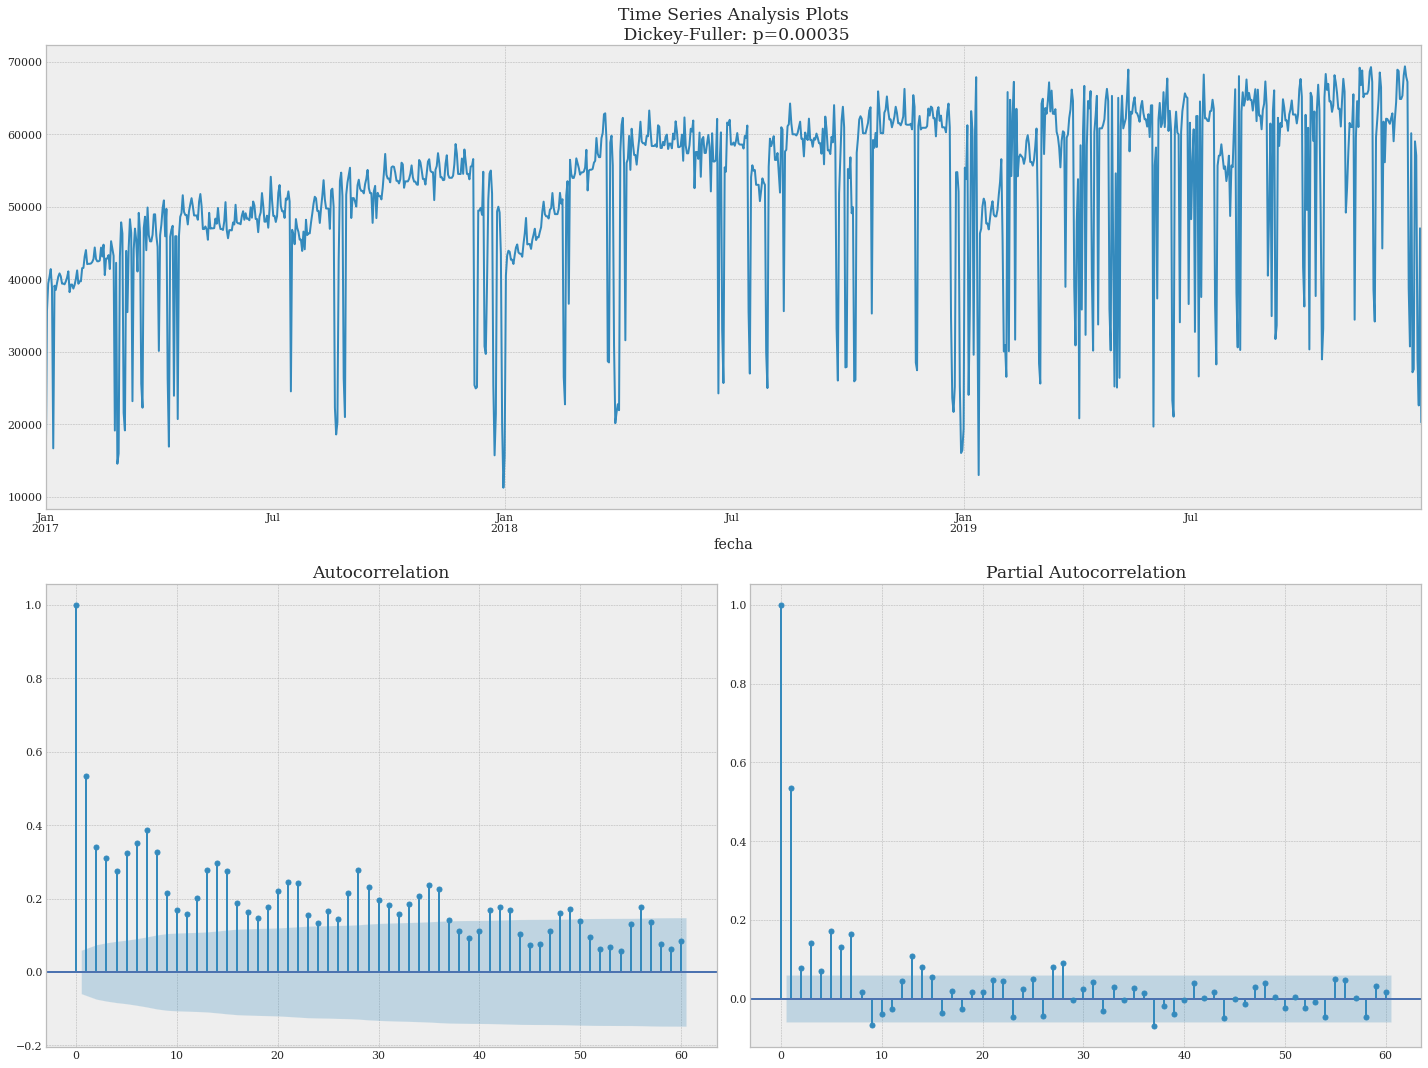

In [49]:
tsplot(w.cantidad_pasos_filtro, lags=60)

Esta grafica se lee de forma similar a la descripta anteriormente. 

In [50]:
# setting initial values and some bounds for them
ps = range(3, 8)
d= 0
qs = range(0, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is still 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)  #

100

In [51]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(w.cantidad_pasos_filtro, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [52]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 3min 56s


In [53]:
result_table.head()

parameters           aic
0  (3, 1, 0, 1)  22918.936080
1  (3, 2, 0, 1)  22936.048823
2  (6, 3, 0, 1)  22957.137213
3  (4, 1, 0, 1)  22957.696320
4  (6, 3, 1, 1)  22958.817139

In [54]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(w.cantidad_pasos_filtro, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:             cantidad_pasos_filtro   No. Observations:                 1095
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -11453.468
Date:                           Fri, 19 Mar 2021   AIC                          22918.936
Time:                                   23:18:24   BIC                          22948.889
Sample:                               01-01-2017   HQIC                         22930.273
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3441      0.032     42.390      0.000       1.282       1.406
ar.L2         -0.3734      0.032    -11.557

La tabla resumen nos indica que el tercer coeficiente de la parte autoregresiva es insignificante.

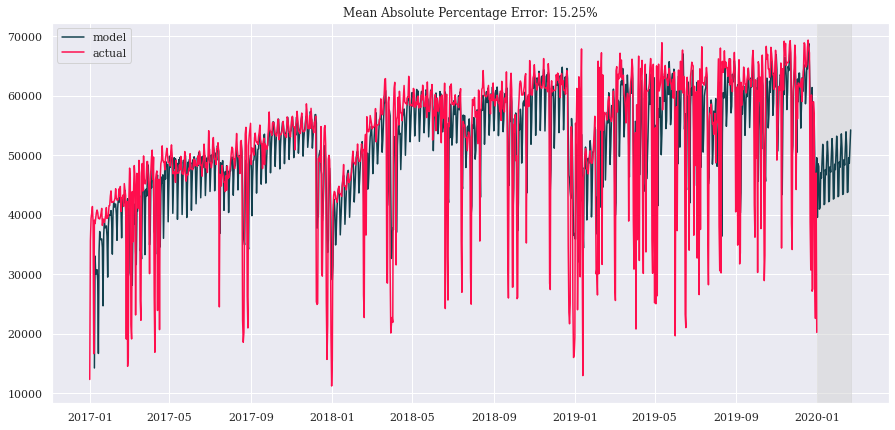

In [55]:
plotSARIMA(w, best_model, 50)

De igual manera que el caso anterior, hemos tenido un error del 15.25% lo cual es inferior al modelo base con el cual arrancamos.

A continuación, entrenaremos un par de modelos simples con el objetivo de contrastar los anteriores resultados.

<a id="s-3"></a>
# Retrasos de series de tiempo
Desplazando la serie n pasos hacia atrás, obtenemos una columna de características donde el valor actual de la serie de tiempo está alineado con su valor en el tiempo t − n. Si hacemos un cambio de 1 retraso y entrenamos un modelo en esa característica, el modelo podrá pronosticar 1 paso por delante de haber observado el estado actual de la serie. Aumentar el retraso, digamos, hasta 6, permitirá que el modelo haga predicciones 6 pasos por delante; sin embargo, utilizará los datos observados 6 pasos atrás. Si algo cambia fundamentalmente la serie durante ese período no observado, el modelo no detectará estos cambios y devolverá pronósticos con un gran error. Por lo tanto, durante la selección del rezago inicial, se debe encontrar un equilibrio entre la calidad de predicción óptima y la longitud del horizonte de predicción.

# Regrasión Lineal

In [56]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(u.cantidad_pasos_filtro.copy())
data.columns = ["y"]

In [57]:
#Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [58]:
# take a look at the new dataframe 
data.tail(2)

y    lag_6    lag_7    lag_8    lag_9   lag_10   lag_11  \
fecha                                                                     
2019-12-30  34523  24220.0  42531.0  32337.0  39303.0  46128.0  45241.0   
2019-12-31  21447  24349.0  24220.0  42531.0  32337.0  39303.0  46128.0   

             lag_12   lag_13   lag_14   lag_15   lag_16   lag_17   lag_18  \
fecha                                                                       
2019-12-30  44687.0  43597.0  41588.0  32774.0  40478.0  49027.0  45099.0   
2019-12-31  45241.0  44687.0  43597.0  41588.0  32774.0  40478.0  49027.0   

             lag_19   lag_20   lag_21   lag_22   lag_23   lag_24  
fecha                                                             
2019-12-30  38546.0  29518.0  37518.0  38839.0  43076.0  38676.0  
2019-12-31  45099.0  38546.0  29518.0  37518.0  38839.0  43076.0

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [60]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [61]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [62]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [63]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    rc('text', usetex=False)
    rc('font', family='serif')
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

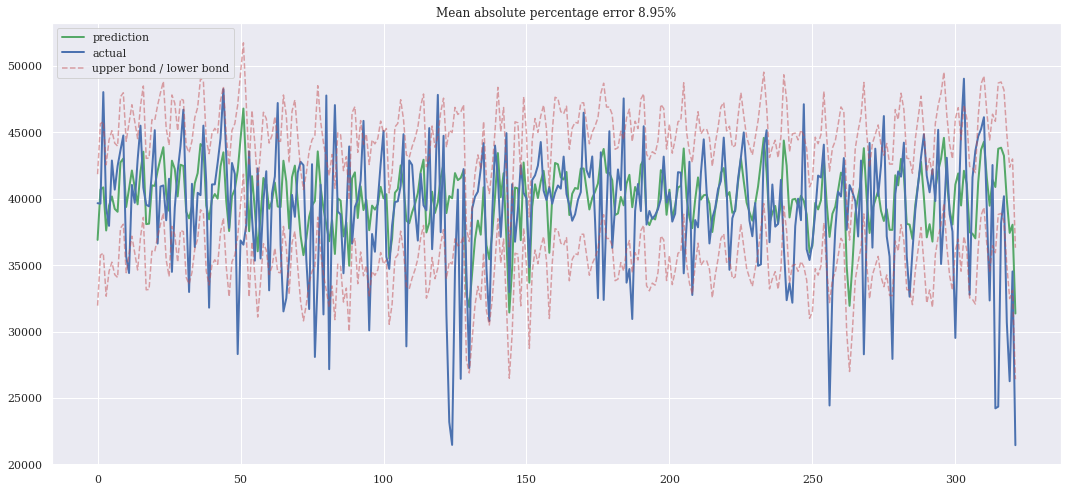

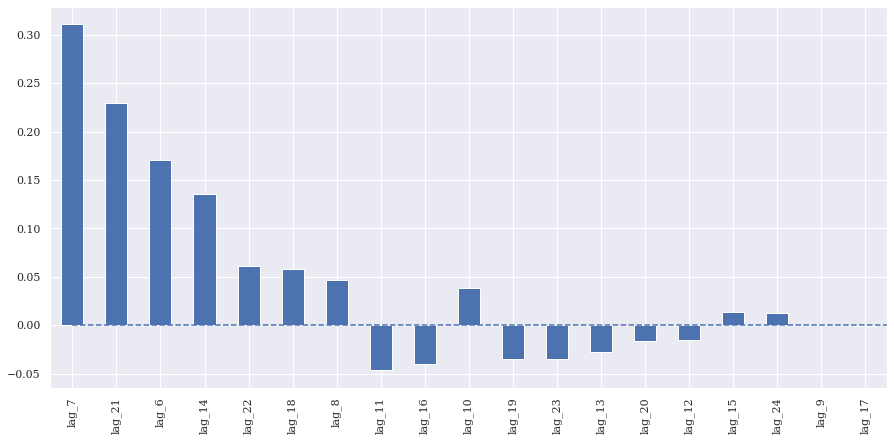

In [64]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Los retrasos simples y la regresión lineal nos dieron predicciones que no están tan lejos de SARIMA en términos de calidad. Hay muchas funciones innecesarias, por lo que haremos una selección de funciones en un momento.

### Datos con escala

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [66]:
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<a id="s-4"></a>
# XGBRegressor

In [67]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

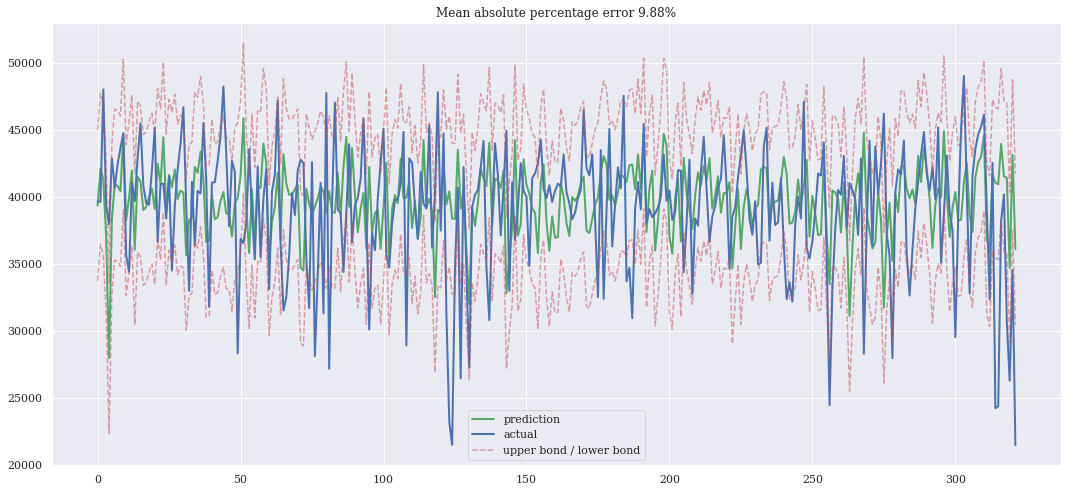

In [68]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)

En este caso tenemos el error más pequeño en el conjunto de prueba entre todos los modelos que hemos probado hasta ahora.
Puede que no sea la mejor idea encajar ``xgboost`` tan pronto como tenga en sus manos los datos de series de tiempo. 

Generalmente, los modelos basados en árboles manejan mal las tendencias en los datos en comparación con los modelos lineales. En ese caso, primero tendrías que cambiar la tendencia de tu serie o usar algunos trucos para hacer que la magia suceda. Idealmente, puede hacer que la serie sea estacionaria y luego usar ``XGBoost``.

<a id="s-5"></a>
# Fbprophet
veremos ahora Prophet, una biblioteca para pronósticos de series de tiempo lanzada por Facebook y de código abierto el 23 de febrero de 2017.

Según el artículo sobre Facebook Research, Prophet se desarrolló inicialmente con el propósito de crear pronósticos comerciales de alta calidad. Esta biblioteca intenta abordar las siguientes dificultades comunes a muchas series de tiempo comerciales:

- Efectos estacionales provocados por el comportamiento humano: ciclos semanales, mensuales y anuales, caídas y picos en días festivos. 

- Cambios de tendencia debido a nuevos productos y eventos del mercado.
Valores atípicos.

- Los autores afirman que, incluso con la configuración predeterminada, en muchos casos, su biblioteca produce pronósticos tan precisos como los entregados por analistas experimentados.

Además, Prophet tiene una serie de personalizaciones intuitivas y fácilmente interpretables que permiten mejorar gradualmente la calidad del modelo de pronóstico. Lo que es especialmente importante, estos parámetros son bastante comprensibles incluso para los no expertos en análisis de series de tiempo, que es un campo de la ciencia de datos que requiere cierta habilidad y experiencia.

In [69]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [70]:
v= pd.DataFrame(u.cantidad_pasos_filtro)
z = pd.DataFrame(w.cantidad_pasos_filtro)

Convirtamos nuestro marco de datos al formato requerido por Prophet:

In [71]:
df = v.reset_index()
df.columns = ['ds', 'y']

df2 = z.reset_index()
df2.columns = ['ds', 'y']
df2.tail(n=3)

ds      y
1092 2019-12-29  22577
1093 2019-12-30  47001
1094 2019-12-31  20232

A continuación vamos a predecir 30 dias a futuro.

In [72]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

train_df2 = df2[:-prediction_size]
train_df2.tail(n=3)

ds      y
1062 2019-11-29  66441
1063 2019-11-30  44225
1064 2019-12-01  61710

Ahora necesitamos crear un nuevo objeto Prophet. Aquí podemos pasar los parámetros del modelo al constructor. Pero en este artículo usaremos los valores predeterminados. Luego, entrenamos nuestro modelo invocando su método de ajuste en nuestro conjunto de datos de entrenamiento:

In [73]:
m = Prophet()
m.fit(train_df);
m2 = Prophet()
m2.fit(train_df2);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Usando el método auxiliar ``Prophet.make_future_dataframe``, creamos un marco de datos que contendrá todas las fechas del historial y también se extenderá hacia el futuro durante esos 30 días que dejamos fuera antes.

In [74]:
future = m.make_future_dataframe(periods=prediction_size)
future2 = m2.make_future_dataframe(periods=prediction_size)

Predecimos valores con Prophet pasando las fechas para las que queremos crear un pronóstico. Si también proporcionamos las fechas históricas (como en nuestro caso), además de la predicción obtendremos un ajuste en la muestra para el historial. Llamemos al método de ``predicción`` del modelo con nuestro marco de datos ``futuro`` como entrada:

In [75]:
forecast = m.predict(future)
forecast2 = m2.predict(future2)
forecast.tail(3)

ds         trend    yhat_lower    yhat_upper   trend_lower  \
1092 2019-12-29  37847.000958  23816.623174  36215.710308  37827.125472   
1093 2019-12-30  37840.283264  28741.414800  40953.055891  37818.961402   
1094 2019-12-31  37833.565570  29742.841925  42254.609078  37809.464403   

       trend_upper  additive_terms  additive_terms_lower  \
1092  37868.312351    -7760.227697          -7760.227697   
1093  37863.575325    -2961.776109          -2961.776109   
1094  37858.171653    -1977.962638          -1977.962638   

      additive_terms_upper       weekly  weekly_lower  weekly_upper  \
1092          -7760.227697 -6065.952659  -6065.952659  -6065.952659   
1093          -2961.776109 -1075.474703  -1075.474703  -1075.474703   
1094          -1977.962638    70.330580     70.330580     70.330580   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1092 -1694.275038  -1694.275038  -1694.275038                   0.0   
1093 -1886.301407  -1886.301407  -1886.301407                   0.0   
1094 -2048.293219  -2048.293219  -2048.293219                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
1092                         0.0                         0.0  30086.773261  
1093                         0.0                         0.0  34878.507155  
1094                         0.0                         0.0  35855.602932

En el marco de datos resultante, puede ver muchas columnas que caracterizan la predicción, incluidos los componentes de ``tendencia y estacionalidad``, así como sus intervalos de confianza. El pronóstico en sí se almacena en la columna ``yhat``.

La biblioteca ``Prophet`` tiene sus propias herramientas de visualización integradas que nos permiten evaluar rápidamente el resultado.

Primero, hay un método llamado Prophet.plot que traza todos los puntos del pronóstico:

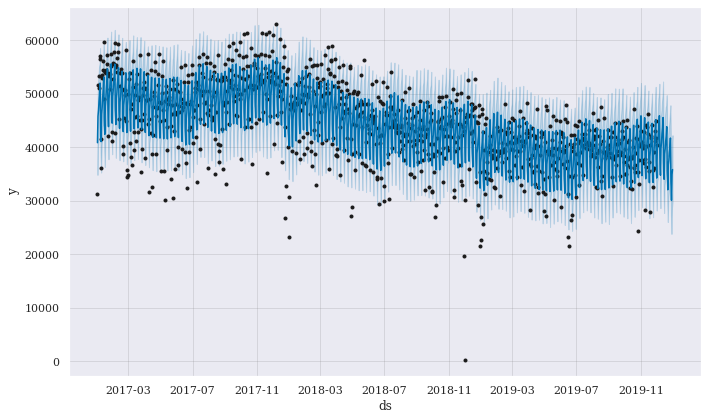

In [76]:
m.plot(forecast);

Comportamiento similar a lo obtenido por los anteriores modelos, pero para ser precisos calculemos el error.

In [77]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [78]:
cmp_df = make_comparison_dataframe(df, forecast)


In [79]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p')}

Calculo del error del Modelo:

In [80]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(f'MAPE :{err_value:0.3f}')

MAPE :14.399


El error es similar al obtenido por el modelo de SARIMA

Este cuadro no parece muy informativo. La única conclusión definitiva que podemos sacar aquí es que el modelo trató muchos de los puntos de datos como valores atípicos.

La segunda función ``Prophet.plot_components`` podría ser mucho más útil en nuestro caso. Nos permite observar diferentes componentes del modelo por separado: tendencia, estacionalidad anual y semanal. Además, si proporciona información sobre vacaciones y eventos a su modelo, también se mostrarán en este gráfico.


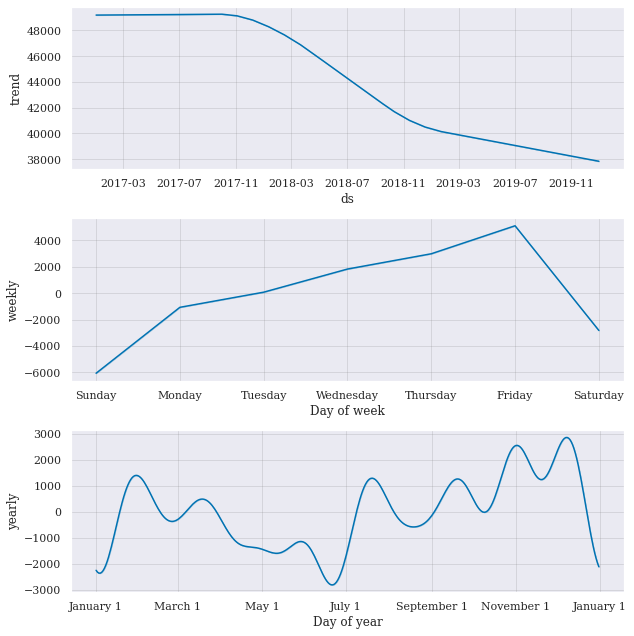

In [81]:
m.plot_components(forecast);

Esta función nos permite contrastar información ya contenida en el tercer proyecto. Como que en el ``2017`` hubierón más vehículos pasando por la estación. También que el dia de la semana con más pasos es el viernes y en Dicciembre y Julio, que son temporadas vacacionales hay menos transitos.

Por ultimo revisemos el comportamiento de la serie estacionaria.

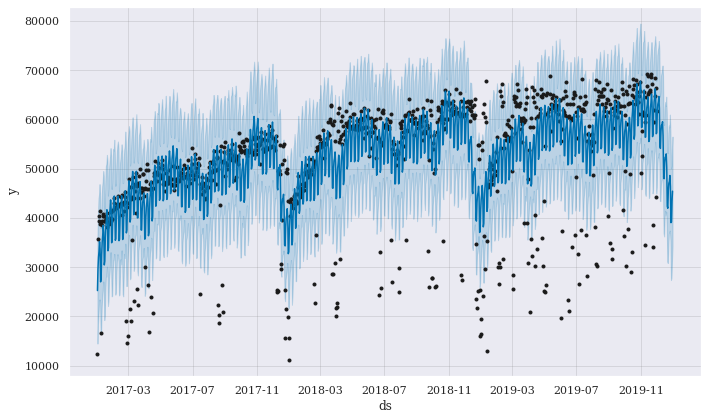

In [82]:
m2.plot(forecast2);

In [83]:
cmp_df2 = make_comparison_dataframe(df2, forecast)

In [84]:
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(f'MAPE :{err_value:0.3f}')

MAPE :34.440


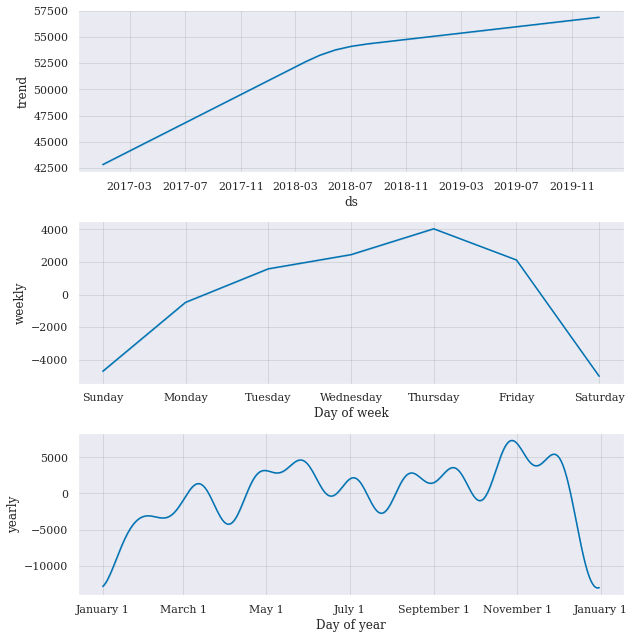

In [85]:
m2.plot_components(forecast2);

Vemos en este caso un comportamiento algo diferente, y es que el jueves el el dia de mayor flujo vehiculo que se paga por telepase. Lo que nos hace pensar que posiblemente se deba a un dia de promoción. En adicción vemos que por el mes de abril cuando se celebra semana santa hay un minímo en el flujo, dicho minímo es mas profundo que el de mitad de año. Indicando que en semana santa la gente prefiere estar en sus casos que pasear.

<a id="s-6"></a>
# Comparación de Modelos

In [86]:
error_modelos = pd.DataFrame({
                        'modelo': ['Benchmark: Holt-Winters', 'Sarima', 'Regresion-Lineal',
                                   'Xgboost','Fbprophet'],
                        'MAPE': [22.59,17.17,8.95,9.88,14.34]
                     })

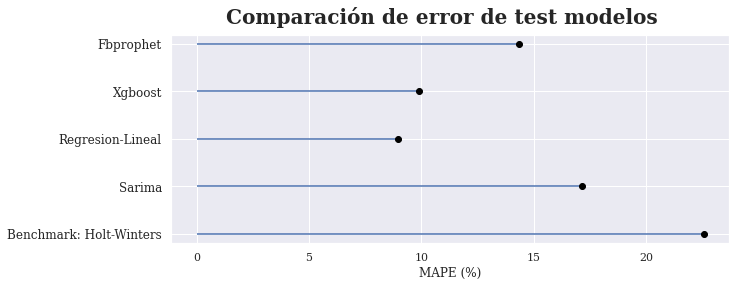

In [87]:
fig = plt.figure(figsize=(10, 3.84)) 
ax1 = plt.subplot(1,1,1) 
ax1.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.MAPE, color ='b')
ax1.plot(error_modelos.MAPE, error_modelos.modelo, "o", color='black')
ax1.tick_params(axis='y', which='major', labelsize=12)
ax1.set_xlabel('MAPE (%)');

fig.suptitle('Comparación de error de test modelos', fontsize = 20, fontweight = "bold");

En este caso con el modelo más simple, que es una regresión lineal hemos obtenido el mejor performance, esto en gran medida se debe a una deficiente optimización de los hiperparámetros de los modelos más exigentes.

Ahora los modelos presentados aquí poseen un mejor performance que los presentados en el proyecto anterior.

<a id="s-7"></a>
# Conclusiones
- Se reafirma con los resultados que `MAPE` no da es un buen indicador del desempeño del pronóstico para los datos que estamos usando. El hecho que se estime una magnitud del error porcentual lo hace un indicador frecuentemente utilizado por los encargados de elaborar pronósticos debido a su fácil interpretación.

- ``SARIMA`` es un método muy robusto, pero su eficiencia radica en escojer adecuadamente sus parámetros, para ello hay que saber ententer muy bien la información contenida en la AFC y PACF para reducir el espacio de parámetros y por ende el tiempo de computo.

- Vemos en la serie de tiempo de Illia pagado por telepase que el jueves el el día de mayor flujo vehicular. Lo que nos hace pensar que posiblemente se deba a un día de promoción. En adicción vemos que por el mes de abril cuando se celebra semana santa hay un minímo en el flujo, dicho minímo es más profundo que el de mitad de año. Indicando que en semana santa la gente prefiere estar en sus casos que pasear.